# HAT Substrate Comparison — Neutral vs Emotional

Compare hardware-level behaviour (interrupts, power, context switches, etc.)
of a Llama-2-7B inference server across two prompt conditions:
**20 neutral** (WikiHow) vs **20 emotional** (Creepypasta) prompts.

**Data per run** (produced by `substrate_collector.py`):

| File | Resolution | Content |
|------|------------|---------|
| `perf_stat.csv` | 1 ms buckets | 16 system-wide perf events — already wide-format CSV |
| `proc_sample.csv` | 200 ms | Per-process CPU + RSS for llama.cpp container |
| `proc_system_sample.csv` | 200 ms | /proc/interrupts, softirqs, PSI, net, disk, CPU freq |
| `responses.jsonl` | per request | LLM timing + tokens evaluated/predicted |

In [66]:
import re, json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (12, 4)

## 1 — Configuration

In [67]:
BASE_DIR = Path.home() / 'Desktop' / 'mccviahat' 

NEUTRAL_RUN   = 'runs/2026-02-16T18-42-38_neutral'
EMOTIONAL_RUN = 'runs/2026-02-16T18-49-38_emotional'

n_dir = BASE_DIR / NEUTRAL_RUN
e_dir = BASE_DIR / EMOTIONAL_RUN

for d in [n_dir, e_dir]:
    assert d.exists(), f'Missing: {d}'
print('Both run directories found')

Both run directories found


## 2 — Loaders

`perf_stat.csv` is already in wide format (one row per ms, one column per event) —
produced by the collector's post-processing step. No parsing needed.

In [68]:
def load_json(path: Path) -> dict:
    return json.loads(path.read_text(encoding='utf-8'))


def load_perf(run_dir: Path) -> pd.DataFrame:
    """Load perf_stat.csv (wide format: t_s, event1, event2, ...)."""
    csv_path = run_dir / 'perf_stat.csv'
    if csv_path.exists():
        return pd.read_csv(csv_path)
    # Fallback: parse perf_stat.txt (handles both -x ',' CSV and legacy human-readable)
    return _parse_perf_stat_legacy(run_dir / 'perf_stat.txt')


def _parse_perf_stat_legacy(path: Path) -> pd.DataFrame:
    """Parse perf stat output — auto-detects -x ',' CSV vs old human-readable format."""
    text = path.read_text(encoding='utf-8', errors='replace')
    lines = text.splitlines()

    # Detect format: -x ',' CSV lines look like "0.001089231,5,,irq:irq_handler_entry,..."
    # Human-readable lines look like "     0.001   5   irq:irq_handler_entry  # ..."
    sample_lines = [l.strip() for l in lines[:50] if l.strip() and not l.strip().startswith('#')]
    is_csv = any(',' in l and len(l.split(',')) >= 4 for l in sample_lines)

    from collections import OrderedDict
    rows_by_ts = OrderedDict()
    events_seen = []

    for line in lines:
        line = line.strip()
        if not line or line.startswith('#'):
            continue

        if is_csv:
            # -x ',' format: timestamp,value,unit,event,runtime,pct,...
            parts = line.split(',')
            if len(parts) < 4:
                continue
            ts_str = parts[0].strip()
            val_str = parts[1].strip()
            event = parts[3].strip()
            if not event:
                continue
            try:
                ts = float(ts_str)
            except ValueError:
                continue
            if val_str.startswith('<') or val_str == '':
                val = np.nan
            else:
                try:
                    val = float(val_str)
                except ValueError:
                    val = np.nan
        else:
            # Legacy human-readable format
            parts = line.split('#', 1)
            tokens = parts[0].strip().split()
            if len(tokens) < 3:
                continue
            try:
                ts = float(tokens[0])
            except ValueError:
                continue
            event = tokens[-1]
            raw_val = tokens[1].replace(',', '')
            val = float(raw_val) if not raw_val.startswith('<') else np.nan

        if event not in events_seen:
            events_seen.append(event)
        if ts not in rows_by_ts:
            rows_by_ts[ts] = {}
        rows_by_ts[ts][event] = val

    # Build wide-format DataFrame
    records = []
    for ts, evts in rows_by_ts.items():
        row = {'t_s': ts}
        for evt in events_seen:
            row[evt] = evts.get(evt, np.nan)
        records.append(row)

    df = pd.DataFrame(records)
    if len(df) > 0:
        df = df.sort_values('t_s').reset_index(drop=True)
    print(f'  Parsed {path.name}: {len(df):,} rows × {len(events_seen)} events')
    return df


def load_responses(run_dir: Path) -> pd.DataFrame:
    """Load responses.jsonl and extract llama.cpp timings."""
    rows = []
    for line in (run_dir / 'responses.jsonl').read_text(encoding='utf-8').splitlines():
        if not line.strip():
            continue
        r = json.loads(line)
        try:
            resp = json.loads(r['response_raw'])
            timings = resp.get('timings', {})
            r['prompt_ms']         = timings.get('prompt_ms')
            r['predicted_ms']      = timings.get('predicted_ms')
            r['tokens_evaluated']  = resp.get('tokens_evaluated')
            r['tokens_predicted']  = resp.get('tokens_predicted')
        except Exception:
            pass
        rows.append(r)
    df = pd.DataFrame(rows)
    keep = [c for c in ['id', 'title', 'ok', 't_request_start_ns', 't_request_end_ns',
                         'prompt_ms', 'predicted_ms', 'tokens_evaluated', 'tokens_predicted']
            if c in df.columns]
    df = df[keep].sort_values('t_request_start_ns').reset_index(drop=True)
    df['duration_s'] = (df['t_request_end_ns'] - df['t_request_start_ns']) / 1e9
    return df


def load_proc_system(run_dir: Path) -> pd.DataFrame:
    df = pd.read_csv(run_dir / 'proc_system_sample.csv')
    df['t_s'] = (df['timestamp_ns'] - df['timestamp_ns'].iloc[0]) / 1e9
    return df


def load_proc_sample(run_dir: Path) -> pd.DataFrame:
    df = pd.read_csv(run_dir / 'proc_sample.csv')
    df['t_s'] = (df['timestamp_ns'] - df['timestamp_ns'].iloc[0]) / 1e9
    return df

## 3 — Load data

In [69]:
n_cmeta = load_json(n_dir / 'collector_meta.json')
e_cmeta = load_json(e_dir / 'collector_meta.json')

n_resp = load_responses(n_dir)
e_resp = load_responses(e_dir)

n_perf = load_perf(n_dir)
e_perf = load_perf(e_dir)

n_sys = load_proc_system(n_dir)
e_sys = load_proc_system(e_dir)

n_proc = load_proc_sample(n_dir)
e_proc = load_proc_sample(e_dir)

n_meta = load_json(n_dir / 'meta.json')
e_meta = load_json(e_dir / 'meta.json')

# Derive common events (columns present in both perf DataFrames, minus t_s)
common_events = sorted(set(n_perf.columns) & set(e_perf.columns) - {'t_s'})

print(f'Perf events ({len(common_events)}): {common_events}')
print(f'Perf rows   — neutral: {len(n_perf):,}   emotional: {len(e_perf):,}')
print(f'Responses   — neutral: {len(n_resp)}/20   emotional: {len(e_resp)}/20')
print(f'Run duration — neutral: {n_perf["t_s"].max():.0f}s   emotional: {e_perf["t_s"].max():.0f}s')

Perf events (16): ['context-switches', 'core_power.throttle', 'cpu-clock', 'cpu-migrations', 'irq:irq_handler_entry', 'irq:irq_handler_exit', 'irq:softirq_entry', 'irq:softirq_exit', 'irq:softirq_raise', 'irq:tasklet_entry', 'irq:tasklet_exit', 'msr/cpu_thermal_margin/', 'page-faults', 'power/energy-pkg/', 'power/energy-ram/', 'tlb:tlb_flush']
Perf rows   — neutral: 42,778   emotional: 41,844
Responses   — neutral: 20/20   emotional: 20/20
Run duration — neutral: 367s   emotional: 360s


## 4 — Request timing

Each prompt is sent sequentially. `tokens_evaluated` reflects prompt length (input),
`tokens_predicted` is fixed at 50 (`n_predict=50`). `duration_s` is the wall-clock
time for one request — this becomes `window_duration_s` in later feature extraction.

In [70]:
show_cols = ['id', 'title', 'duration_s', 'tokens_evaluated', 'tokens_predicted', 'prompt_ms', 'predicted_ms']
print(f'=== Neutral ({len(n_resp)}/{20} completed) ===')
display(n_resp[show_cols])
print(f'\n=== Emotional ({len(e_resp)}/{20} completed) ===')
display(e_resp[show_cols])

=== Neutral (20/20 completed) ===


,id,title,duration_s,tokens_evaluated,tokens_predicted,prompt_ms,predicted_ms
0,1,How to Raise a Perfect Garchomp,17.865000,699,50,10447.050,7394.313
1,2,How to Create Glow in the Dark Log Campfire St...,16.721919,610,50,8964.182,7741.240
2,3,How to Eat Honeycomb,19.289169,758,50,11013.852,8261.422
3,4,How to Make Your Own Skin in Minecraft,17.774635,634,50,9348.099,8411.047
4,5,How to Learn a Piano Piece Quickly,16.950278,557,50,8185.078,8198.781
5,6,How to Make Medical Marijuana Brownies,17.760926,627,50,9193.889,8002.723
6,7,How to Make Waterproof Matches,17.806412,619,50,9063.112,8151.828
7,8,How to Write a Speech if You're Third Speaker,16.427911,560,50,8185.296,7863.942
8,9,How to Create a Hot Compress for Acne Treatmen...,18.109121,659,50,9589.465,8133.738
9,10,How to Clean Tennis Balls,17.373354,600,50,8847.010,8002.956



=== Emotional (20/20 completed) ===


,id,title,duration_s,tokens_evaluated,tokens_predicted,prompt_ms,predicted_ms
0,1,Stairs,17.293115,635,50,9810.044,7462.235
1,2,The Kaleidoscope,17.079028,616,50,9090.135,7972.427
2,3,I Told You To Smile,16.837082,626,50,9176.096,7645.834
3,4,Tower of Silence,16.582779,593,50,8717.225,7850.046
4,5,The Boogey Man,17.370184,619,50,9005.991,7966.676
5,6,The Window,16.587285,579,50,8465.167,7784.288
6,7,Branches in the Wind,18.507763,702,50,10130.493,8047.757
7,8,Hope,17.085992,587,50,8638.905,8031.935
8,9,Where Bad Kids Go,17.550264,633,50,9151.372,7886.540
9,10,Lazy Saturday Night,18.548492,700,50,10150.045,7937.194


## 5 — Perf event overview

Mean event count per 1 ms bucket across the entire run. This is a first look —
if the means differ, the time-series and per-request features (§6) will tell us more.

In [71]:
common_events = sorted(set(n_perf.columns) & set(e_perf.columns) - {'t_s'})
print(f'Events in both runs ({len(common_events)}):\n')
print(f'{"Event":35s}  {"Neutral mean":>14s}  {"Emotional mean":>14s}')
print('-' * 68)
for e in common_events:
    print(f'{e:35s}  {n_perf[e].mean():14.2f}  {e_perf[e].mean():14.2f}')

Events in both runs (16):

Event                                  Neutral mean  Emotional mean
--------------------------------------------------------------------
context-switches                            1296.67         1321.86
core_power.throttle                      3411953.38      3400609.19
cpu-clock                                    549.52          550.43
cpu-migrations                               170.82          172.88
irq:irq_handler_entry                          1.10            1.11
irq:irq_handler_exit                           1.10            1.11
irq:softirq_entry                             96.35           97.94
irq:softirq_exit                              96.35           97.94
irq:softirq_raise                             96.73           98.29
irq:tasklet_entry                              0.00            0.00
irq:tasklet_exit                               0.00            0.00
msr/cpu_thermal_margin/                     3442.21         3602.28
page-faults         

## 6 — Time-series visualisation

Smoothed (rolling mean) time-series for key perf events. Shaded bands = request windows.
This helps spot obvious patterns (e.g. thermal drift, burst clusters) before formal testing.

In [72]:
def request_windows(resp, t0_ns):
    return [(float(r['t_request_start_ns'] - t0_ns) / 1e9,
             float(r['t_request_end_ns']   - t0_ns) / 1e9)
            for _, r in resp.iterrows()]

n_wins = request_windows(n_resp, n_cmeta['t0_ns'])
e_wins = request_windows(e_resp, e_cmeta['t0_ns'])

baseline_s = n_meta.get('baseline_s', 3.0)
run_dur_ms = max(n_perf['t_s'].max(), e_perf['t_s'].max()) * 1000
SMOOTH_MS = int(np.clip(run_dur_ms * 0.01, 500, 5000))


def plot_event(evt, smooth_ms=None):
    if smooth_ms is None:
        smooth_ms = SMOOTH_MS
    if evt not in n_perf.columns or evt not in e_perf.columns:
        print(f'  {evt} not in both runs — skipping.')
        return
    fig, axes = plt.subplots(1, 2, figsize=(14, 3.5), sharey=True)
    for ax, label, df, wins, color in [
        (axes[0], 'Neutral',   n_perf, n_wins, 'steelblue'),
        (axes[1], 'Emotional', e_perf, e_wins, 'firebrick'),
    ]:
        smoothed = df[evt].rolling(smooth_ms, min_periods=1).mean()
        ax.plot(df['t_s'], smoothed, color=color, lw=0.8, alpha=0.9)
        for s, e in wins:
            ax.axvspan(s, e, alpha=0.10, color=color)
        ax.axvline(baseline_s, ls=':', color='gray', lw=0.5)
        ax.set_title(f'{label} — {evt}')
        ax.set_xlabel('time (s)')
    axes[0].set_ylabel(f'rolling {smooth_ms}ms mean')
    plt.tight_layout()
    plt.show()

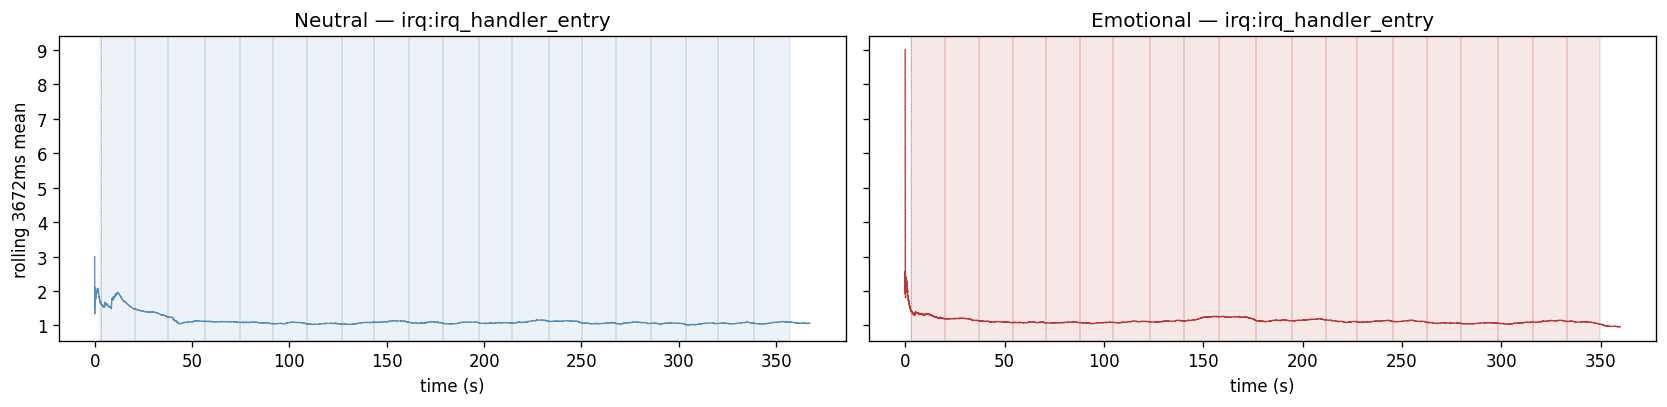

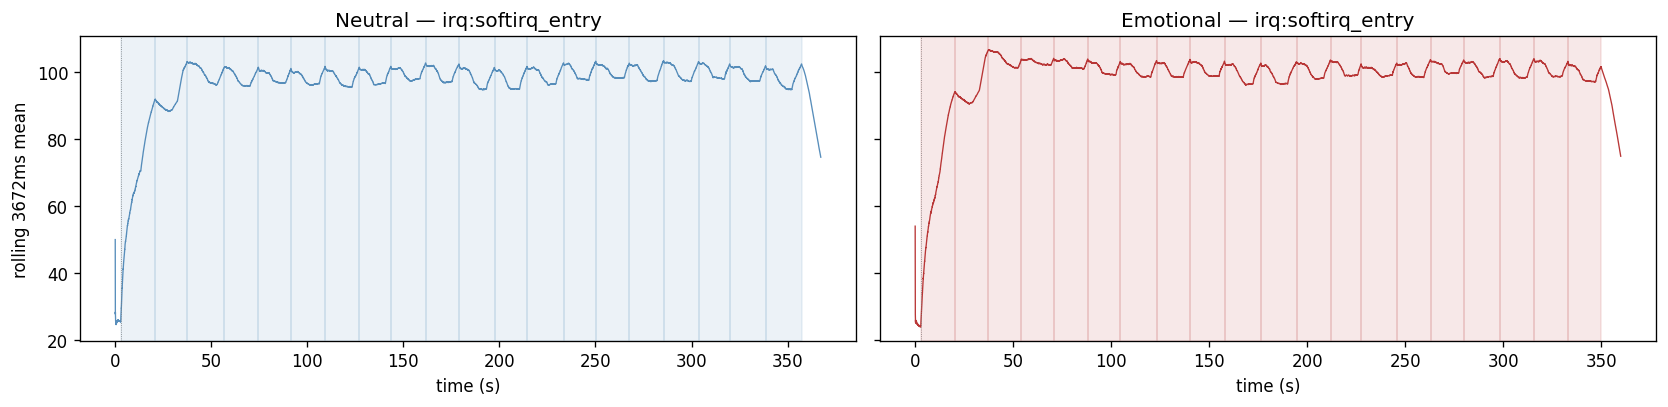

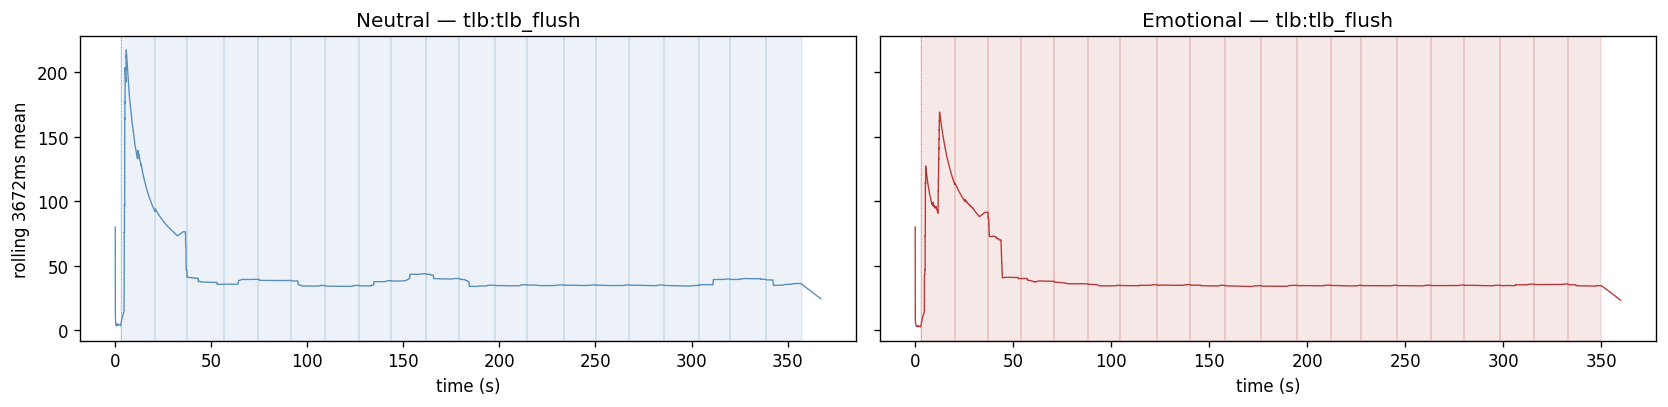

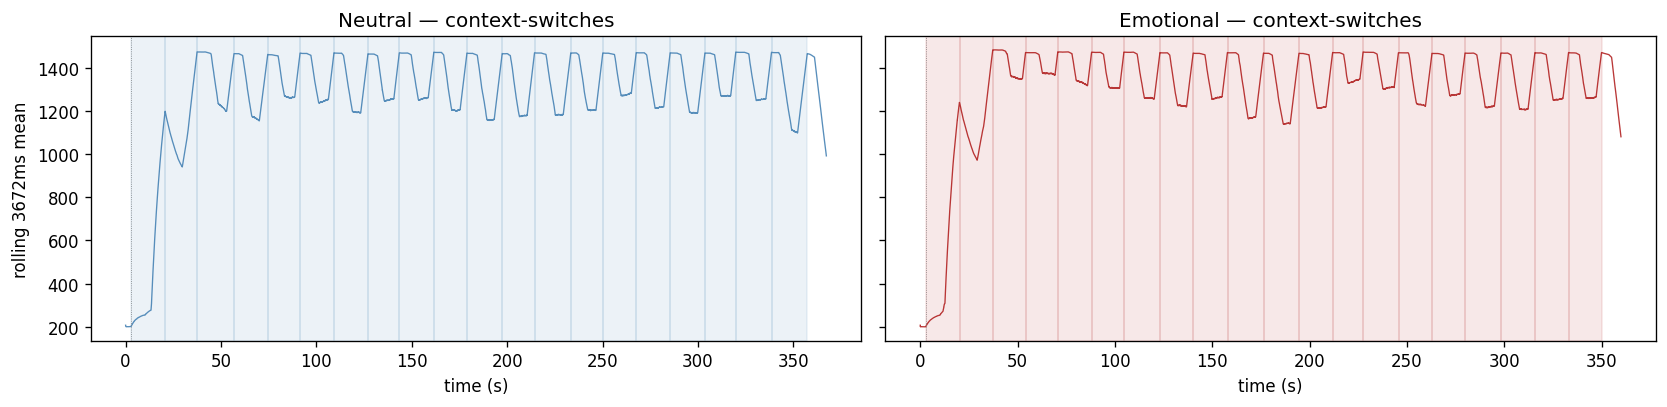

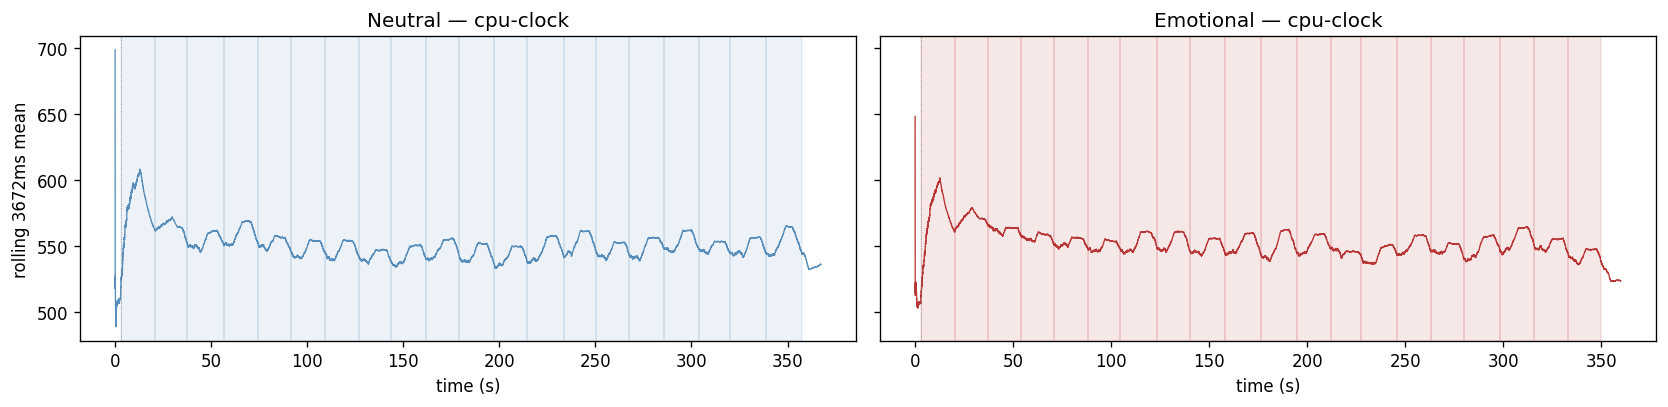

In [73]:
for evt in ['irq:irq_handler_entry', 'irq:softirq_entry', 'tlb:tlb_flush',
            'context-switches', 'cpu-clock']:
    plot_event(evt)

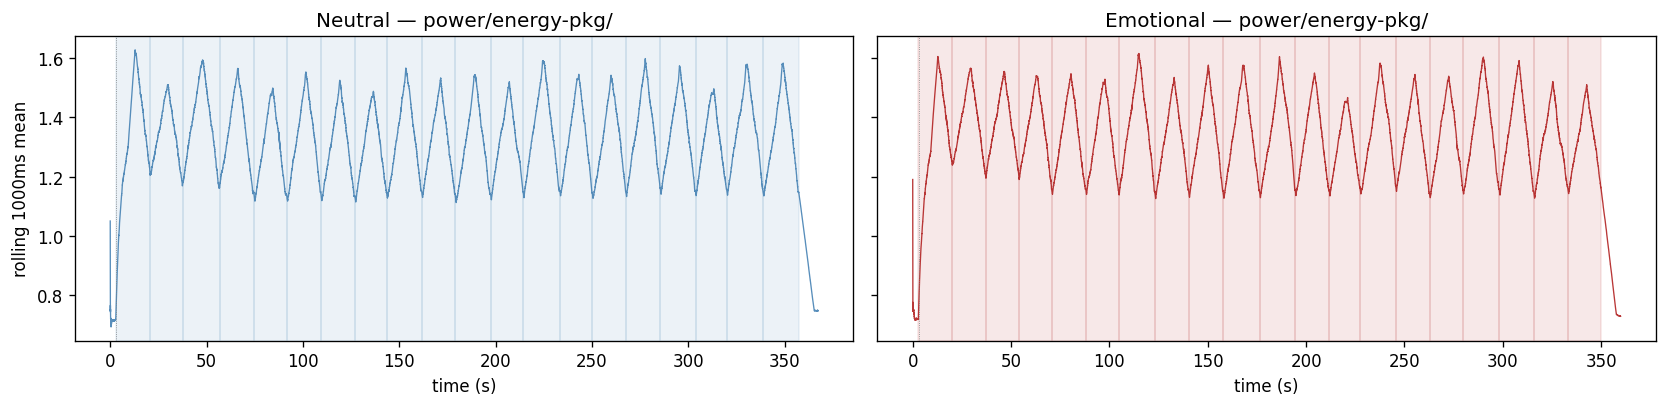

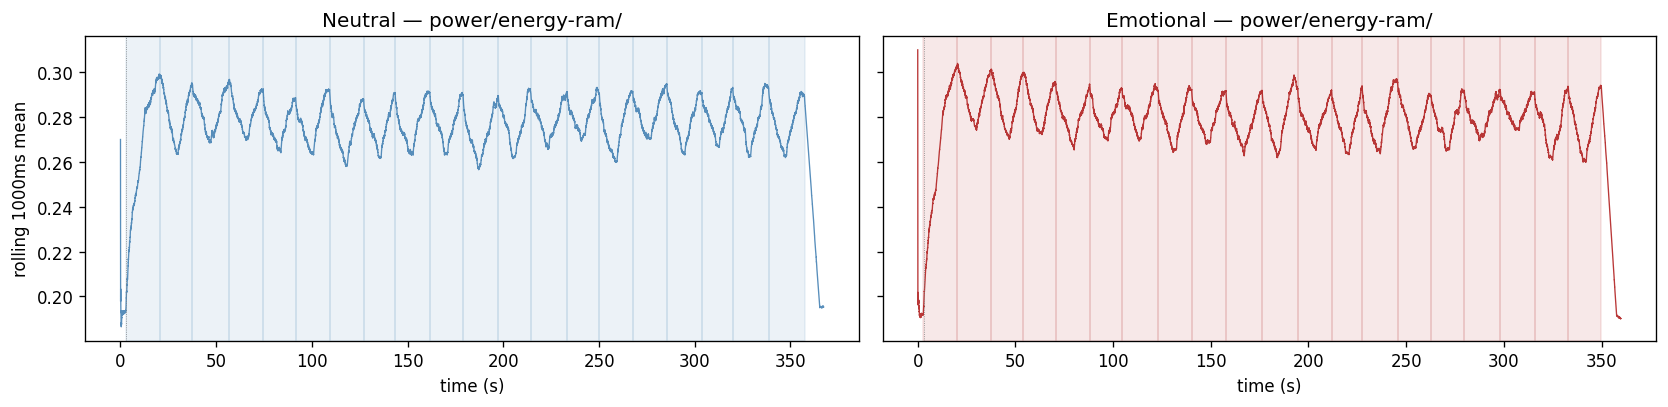

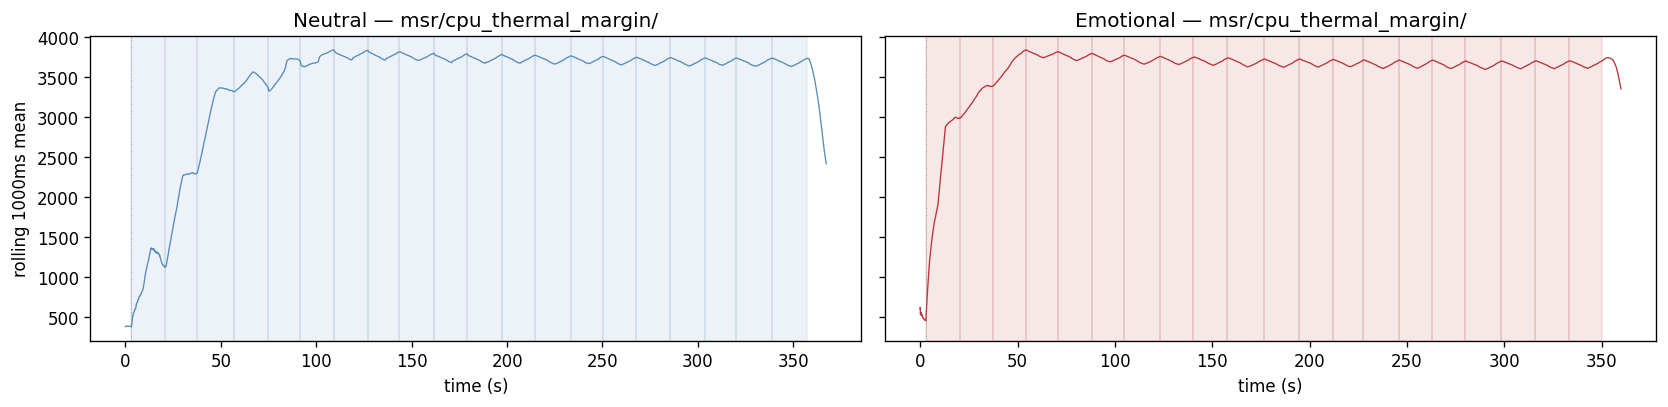

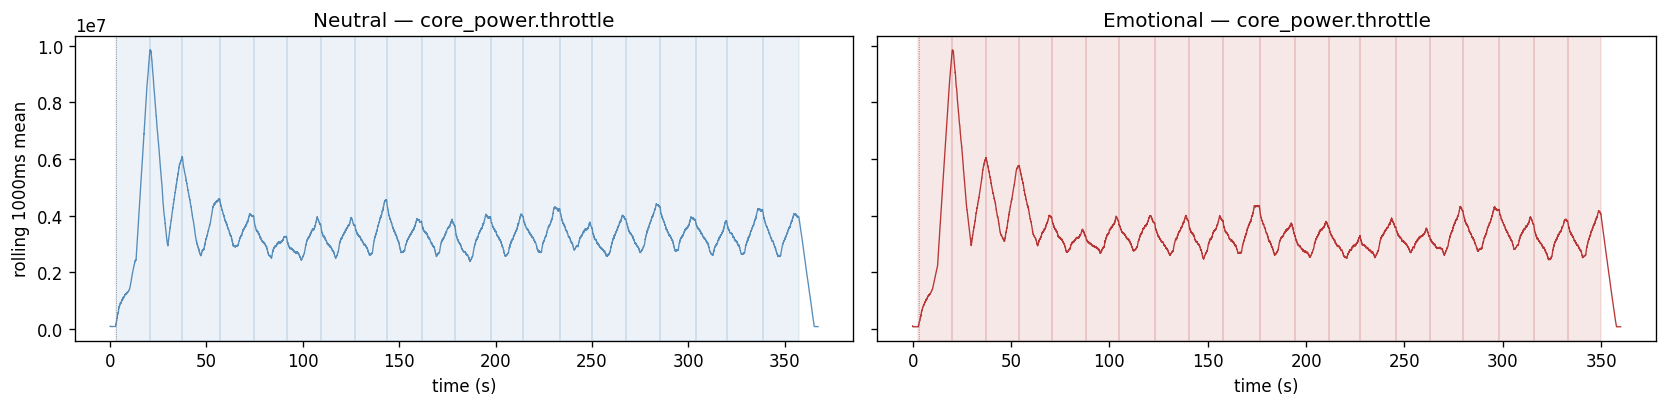

In [74]:
for evt in ['power/energy-pkg/', 'power/energy-ram/', 'msr/cpu_thermal_margin/', 'core_power.throttle']:
    plot_event(evt, smooth_ms=1000)

## 7 — Per-process CPU & /proc softirqs

`proc_sample.csv` tracks llama.cpp CPU jiffies at 200 ms. Differencing gives
approximate CPU utilisation per interval.

**Known issue:** The collector tracks the Docker exec wrapper PID, not the actual
llama-server process, so `proc_cpu_frac` may be inaccurate.

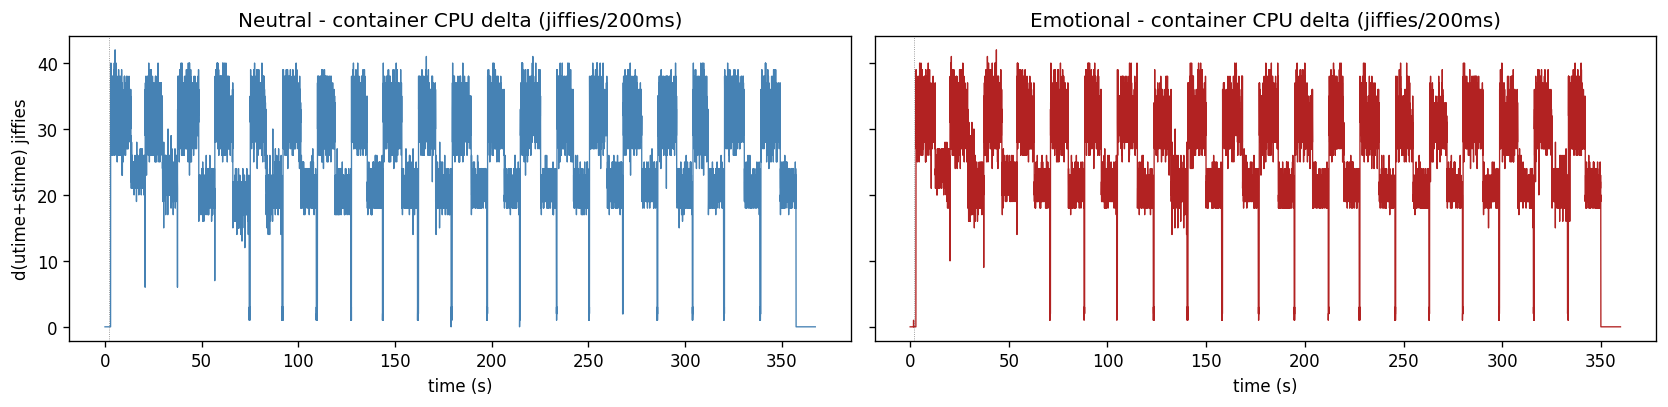

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(14, 3.5), sharey=True)
for ax, label, df, color in [
    (axes[0], 'Neutral',   n_proc, 'steelblue'),
    (axes[1], 'Emotional', e_proc, 'firebrick'),
]:
    cpu = (df['proc_utime_jiffies'] + df['proc_stime_jiffies']).diff()
    ax.plot(df['t_s'], cpu, color=color, lw=0.8)
    ax.axvline(2.0, ls=':', color='gray', lw=0.5)
    ax.set_title(f'{label} - container CPU delta (jiffies/200ms)')
    ax.set_xlabel('time (s)')
axes[0].set_ylabel('d(utime+stime) jiffies')
plt.tight_layout()
plt.show()

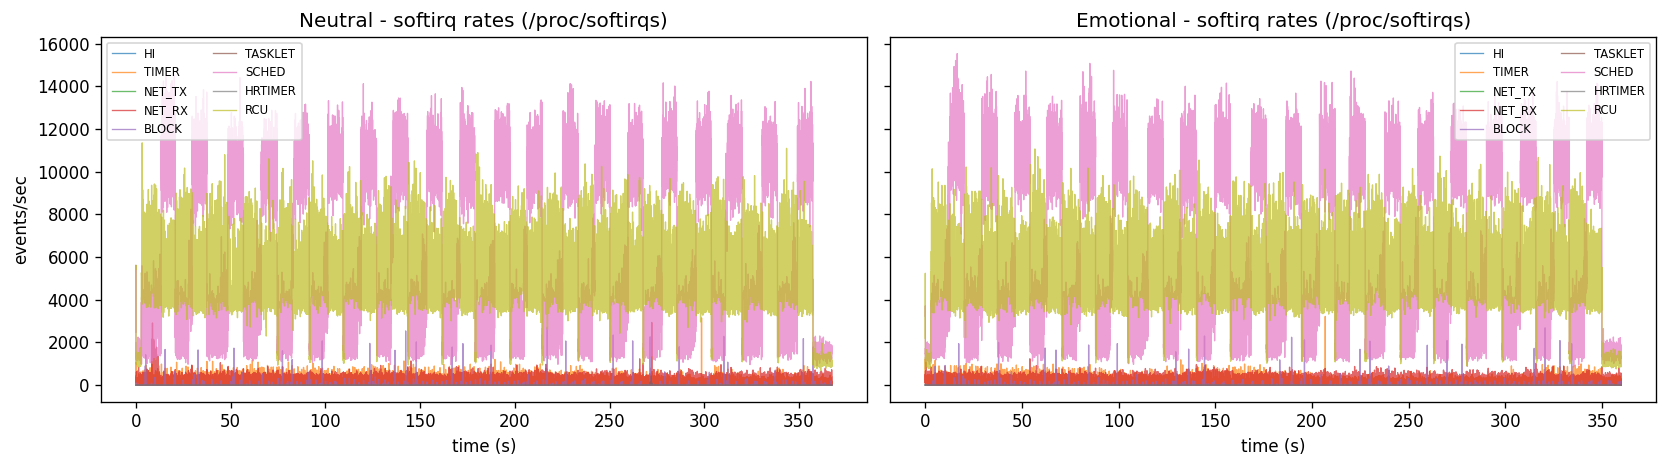

In [76]:
softirq_names = ['HI', 'TIMER', 'NET_TX', 'NET_RX', 'BLOCK', 'TASKLET', 'SCHED', 'HRTIMER', 'RCU']
available_sirqs = [s for s in softirq_names if s in n_sys.columns]

if available_sirqs:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
    for ax, label, df, color in [
        (axes[0], 'Neutral',   n_sys, 'steelblue'),
        (axes[1], 'Emotional', e_sys, 'firebrick'),
    ]:
        for sirq in available_sirqs:
            rate = df[sirq].diff() / df['t_s'].diff()
            ax.plot(df['t_s'], rate, lw=0.8, alpha=0.7, label=sirq)
        ax.set_title(f'{label} - softirq rates (/proc/softirqs)')
        ax.set_xlabel('time (s)')
        ax.legend(fontsize=7, ncol=2)
    axes[0].set_ylabel('events/sec')
    plt.tight_layout()
    plt.show()
else:
    print('No softirq columns found')

In [77]:
# Quick data quality check
print('── Data Quality ──')
for evt in common_events:
    n_sum, e_sum = n_perf[evt].sum(), e_perf[evt].sum()
    if n_sum == 0 and e_sum == 0:
        print(f'  ⚠ {evt}: zero in both runs')
    elif n_sum == 0 or e_sum == 0:
        print(f'  ⚠ {evt}: zero in {"neutral" if n_sum == 0 else "emotional"} only')

dup_cols = n_sys.columns[n_sys.columns.duplicated()].tolist()
if dup_cols:
    print(f'  ⚠ Duplicate columns in proc_system_sample: {set(dup_cols)}')

── Data Quality ──
  ⚠ irq:tasklet_entry: zero in emotional only
  ⚠ irq:tasklet_exit: zero in emotional only


## 8 — Feature Engineering

Each prompt's request window (start → end in the perf time-series) becomes one
observation. We extract features in 5 categories from the 1 ms event counts:

| Category | Features | What it captures |
|----------|----------|-----------------|
| **Frequency** | event rate, relative share | How often each interrupt fires per second |
| **Temporal** | inter-arrival entropy, Fano factor | Regularity vs burstiness of event timing |
| **Burst** | burst count/rate/size/duration/clustering | Concentrated activity patterns |
| **Coupling** | cross-correlation, mutual information | Interaction between event pairs |
| **Complexity** | Lempel-Ziv, permutation entropy | Randomness vs structure in the signal |

This gives ~160 features per prompt (after dropping zero-variance columns).

In [78]:
from scipy import stats as sp_stats
from collections import defaultdict

def extract_request_series(perf_df, wins, events=None):
    """Return list of dicts {event: np.array} for each request window."""
    if events is None:
        events = [c for c in perf_df.columns if c != 't_s']
    segments = []
    for start, end in wins:
        mask = (perf_df['t_s'] >= start) & (perf_df['t_s'] <= end)
        seg = {evt: perf_df.loc[mask, evt].values.astype(float) for evt in events}
        seg['_t_s'] = perf_df.loc[mask, 't_s'].values
        seg['_duration_s'] = end - start
        segments.append(seg)
    return segments

n_segs = extract_request_series(n_perf, n_wins, common_events)
e_segs = extract_request_series(e_perf, e_wins, common_events)
print(f'Segments: {len(n_segs)} neutral, {len(e_segs)} emotional')

Segments: 20 neutral, 20 emotional


### 8.1 — Frequency features

**Event rate** = total count ÷ window duration (events/s).
**Relative share** = fraction of all events. These capture interrupt *intensity*.

In [79]:
# ── 6.1  Frequency Features ──
def compute_frequency_features(segments, events):
    """Return DataFrame: rows = segments, cols = event_rate, event_share."""
    rows = []
    for seg in segments:
        dur = seg['_duration_s']
        rates = {}
        for evt in events:
            rates[evt] = seg[evt].sum() / dur if dur > 0 else 0.0
        total_rate = sum(rates.values())
        row = {}
        for evt in events:
            row[f'{evt}__rate'] = rates[evt]
            row[f'{evt}__share'] = rates[evt] / total_rate if total_rate > 0 else 0.0
        rows.append(row)
    return pd.DataFrame(rows)

n_freq = compute_frequency_features(n_segs, common_events)
e_freq = compute_frequency_features(e_segs, common_events)

# ── Summary table ──
rate_cols = [c for c in n_freq.columns if c.endswith('__rate')]
summary = []
for col in rate_cols:
    evt = col.replace('__rate', '')
    summary.append({
        'event': evt,
        'neutral_rate_mean': n_freq[col].mean(),
        'neutral_rate_std': n_freq[col].std(),
        'emotional_rate_mean': e_freq[col].mean(),
        'emotional_rate_std': e_freq[col].std(),
        'ratio_E/N': e_freq[col].mean() / n_freq[col].mean() if n_freq[col].mean() > 0 else np.nan,
    })
freq_summary = pd.DataFrame(summary).sort_values('neutral_rate_mean', ascending=False)
print('Event rates (events/s) per request window:\n')
print(freq_summary.to_string(index=False, float_format='{:.2f}'.format))

Event rates (events/s) per request window:

                  event  neutral_rate_mean  neutral_rate_std  emotional_rate_mean  emotional_rate_std  ratio_E/N
    core_power.throttle       411358570.36       73704108.21         409771009.13         78839392.80       1.00
msr/cpu_thermal_margin/          406019.42          74741.97            421413.33            25458.36       1.04
       context-switches          155913.90           6774.27            158688.42             5835.47       1.02
              cpu-clock           64001.23             14.49             63999.97               16.35       1.00
            page-faults           20742.10          20245.67             21020.27            29285.58       1.01
         cpu-migrations           20359.54            755.87             20567.54              657.02       1.01
      irq:softirq_raise           11571.10            185.80             11744.95              171.31       1.02
       irq:softirq_exit           11526.44          

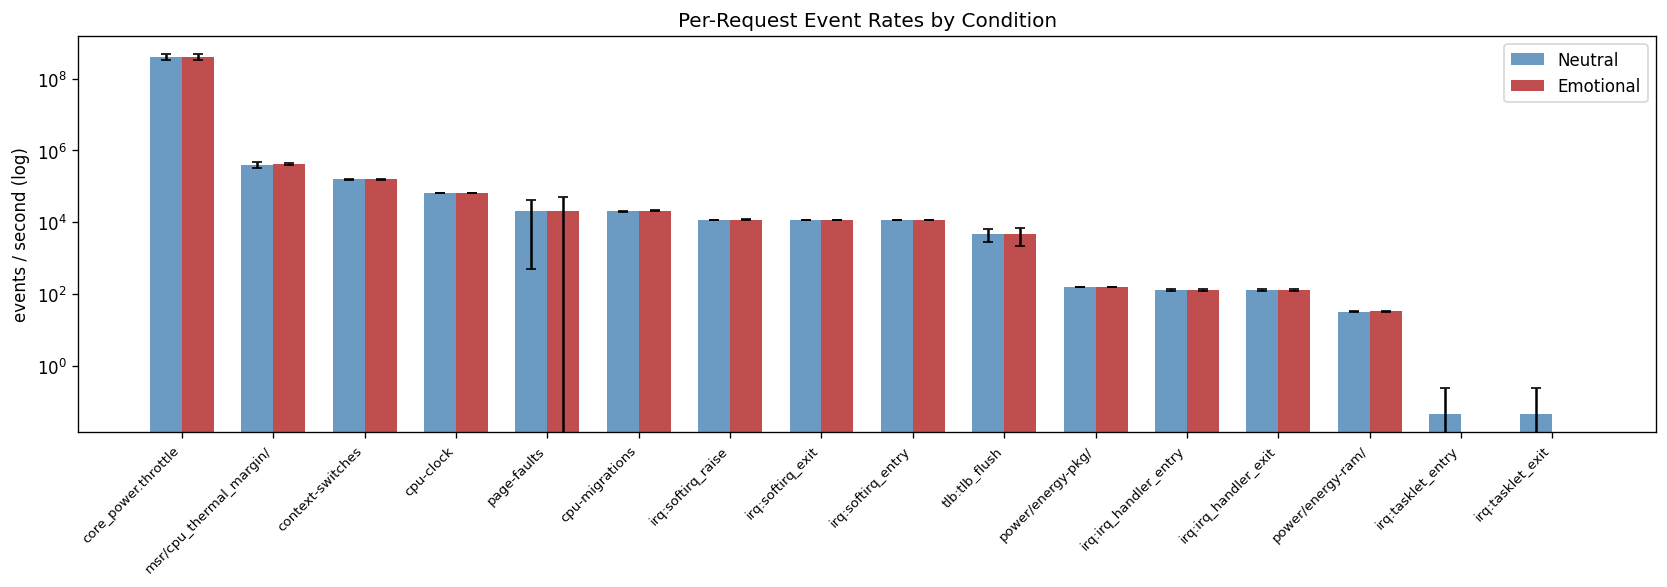

/var/folders/h6/72885xfn72j09dqwjl2d30yw0000gn/T/ipykernel_19566/1897108907.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  textprops={'fontsize': 7}, colors=plt.cm.get_cmap(cmap)(np.linspace(0.3, 0.9, len(plot_shares))))


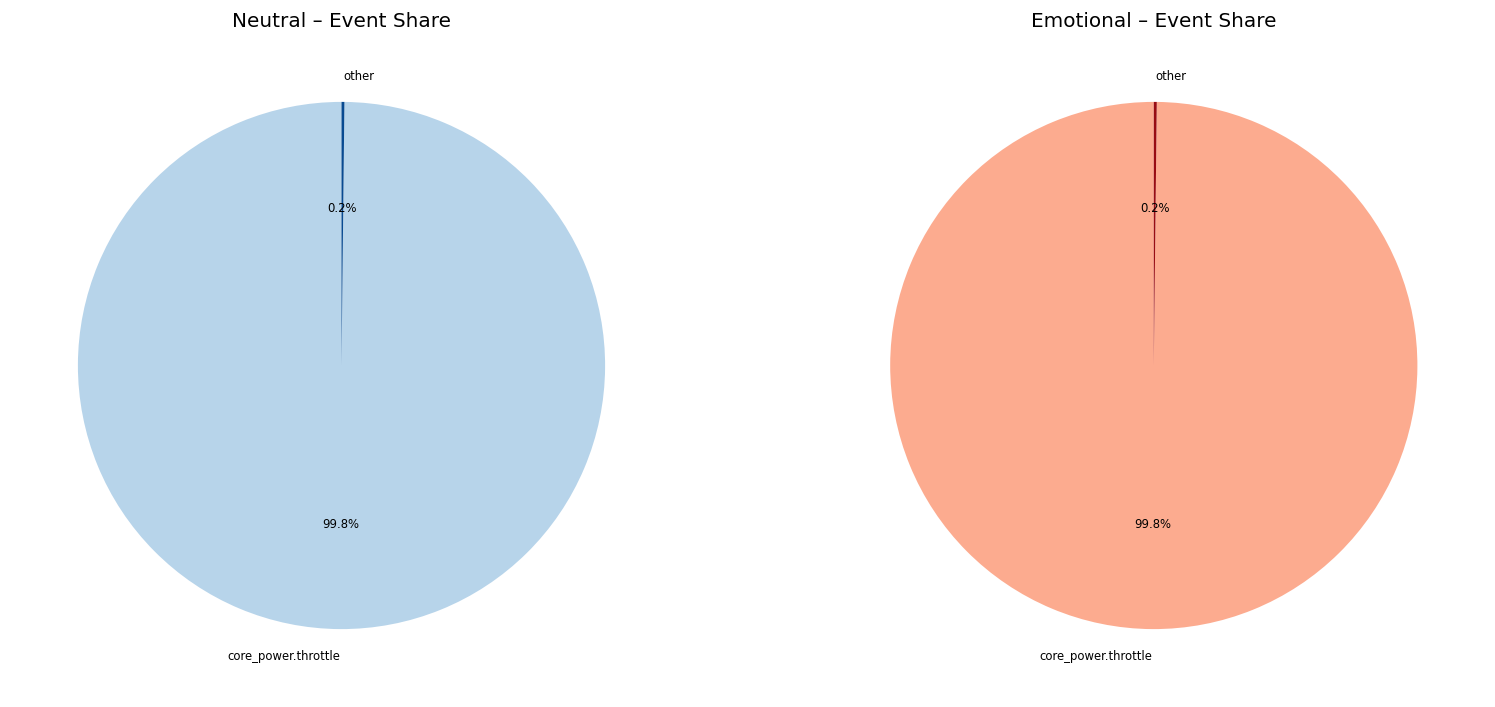

In [80]:
# ── 6.1 plot: Event rates grouped bar ──
rate_events = freq_summary['event'].values
x = np.arange(len(rate_events))
w = 0.35

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(x - w/2, freq_summary['neutral_rate_mean'],  w, yerr=freq_summary['neutral_rate_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=3)
ax.bar(x + w/2, freq_summary['emotional_rate_mean'], w, yerr=freq_summary['emotional_rate_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=3)
ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels(rate_events, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('events / second (log)')
ax.set_title('Per-Request Event Rates by Condition')
ax.legend()
plt.tight_layout()
plt.show()

# ── Relative share pie charts ──
share_cols = [c for c in n_freq.columns if c.endswith('__share')]
n_shares = n_freq[share_cols].mean()
e_shares = e_freq[share_cols].mean()
labels = [c.replace('__share', '') for c in share_cols]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for ax, shares, title, cmap in [
    (axes[0], n_shares.values, 'Neutral – Event Share', 'Blues'),
    (axes[1], e_shares.values, 'Emotional – Event Share', 'Reds'),
]:
    # Collapse tiny slices into "other"
    thresh = 0.02
    big = shares >= thresh
    plot_shares = list(shares[big]) + [shares[~big].sum()]
    plot_labels = [labels[i] for i in range(len(labels)) if big[i]] + ['other']
    ax.pie(plot_shares, labels=plot_labels, autopct='%1.1f%%', startangle=90,
           textprops={'fontsize': 7}, colors=plt.cm.get_cmap(cmap)(np.linspace(0.3, 0.9, len(plot_shares))))
    ax.set_title(title)
plt.tight_layout()
plt.show()

### 8.2 — Temporal structure

**Inter-arrival entropy** (bits): how irregular the spacing between events is.
Higher = more random timing.
**Fano factor** ($F = \sigma^2 / \mu$ in 100 ms bins): $F = 1$ is Poisson,
$F > 1$ is bursty, $F < 1$ is regular.

In [81]:
# ── 6.2  Temporal Structure ──

def shannon_entropy_bits(arr):
    """Shannon entropy of a discrete distribution (in bits)."""
    arr = arr[arr > 0]
    if len(arr) == 0:
        return 0.0
    p = arr / arr.sum()
    return -np.sum(p * np.log2(p))


def inter_arrival_entropy(series):
    """Entropy of inter-arrival time distribution for a 1ms count series."""
    arrivals = np.where(series > 0)[0]  # indices where count > 0
    if len(arrivals) < 2:
        return 0.0
    iat = np.diff(arrivals)  # inter-arrival times in ms
    counts = np.bincount(iat)
    return shannon_entropy_bits(counts.astype(float))


def fano_factor(series, bin_size=100):
    """Fano factor from non-overlapping bins of `bin_size` ms."""
    n_bins = len(series) // bin_size
    if n_bins < 2:
        return np.nan
    trimmed = series[:n_bins * bin_size]
    binned = trimmed.reshape(n_bins, bin_size).sum(axis=1)
    mu = binned.mean()
    if mu == 0:
        return np.nan
    return binned.var(ddof=1) / mu


def compute_temporal_features(segments, events):
    rows = []
    for seg in segments:
        row = {}
        for evt in events:
            s = seg[evt]
            row[f'{evt}__iat_entropy'] = inter_arrival_entropy(s)
            row[f'{evt}__fano'] = fano_factor(s, bin_size=100)
        rows.append(row)
    return pd.DataFrame(rows)

n_temp = compute_temporal_features(n_segs, common_events)
e_temp = compute_temporal_features(e_segs, common_events)

# ── summary ──
temp_summary = []
for evt in common_events:
    ec, fc = f'{evt}__iat_entropy', f'{evt}__fano'
    temp_summary.append({
        'event': evt,
        'n_entropy': n_temp[ec].mean(), 'n_entropy_std': n_temp[ec].std(),
        'e_entropy': e_temp[ec].mean(), 'e_entropy_std': e_temp[ec].std(),
        'n_fano':    n_temp[fc].mean(), 'n_fano_std':    n_temp[fc].std(),
        'e_fano':    e_temp[fc].mean(), 'e_fano_std':    e_temp[fc].std(),
    })
temp_df = pd.DataFrame(temp_summary)
print(f'Temporal Structure features (mean ± std across {len(n_segs)} neutral / {len(e_segs)} emotional prompts):\n')
print(temp_df.to_string(index=False, float_format='{:.3f}'.format))

Temporal Structure features (mean ± std across 20 neutral / 20 emotional prompts):

                  event  n_entropy  n_entropy_std  e_entropy  e_entropy_std       n_fano   n_fano_std       e_fano   e_fano_std
       context-switches      0.000          0.000      0.000          0.000    82895.915     4065.483    83390.105     3014.648
    core_power.throttle      0.000          0.000      0.000          0.000 40420907.434 53901558.021 39710287.679 56502824.066
              cpu-clock      0.000          0.000      0.000          0.000      669.814      114.471      690.684      118.347
         cpu-migrations      0.000          0.000      0.000          0.000     5537.869      251.759     5574.796      223.288
  irq:irq_handler_entry      2.697          0.059      2.666          0.107        5.524       10.000        3.319        1.378
   irq:irq_handler_exit      2.698          0.059      2.666          0.107        5.524       10.000        3.319        1.378
      irq:softirq_en

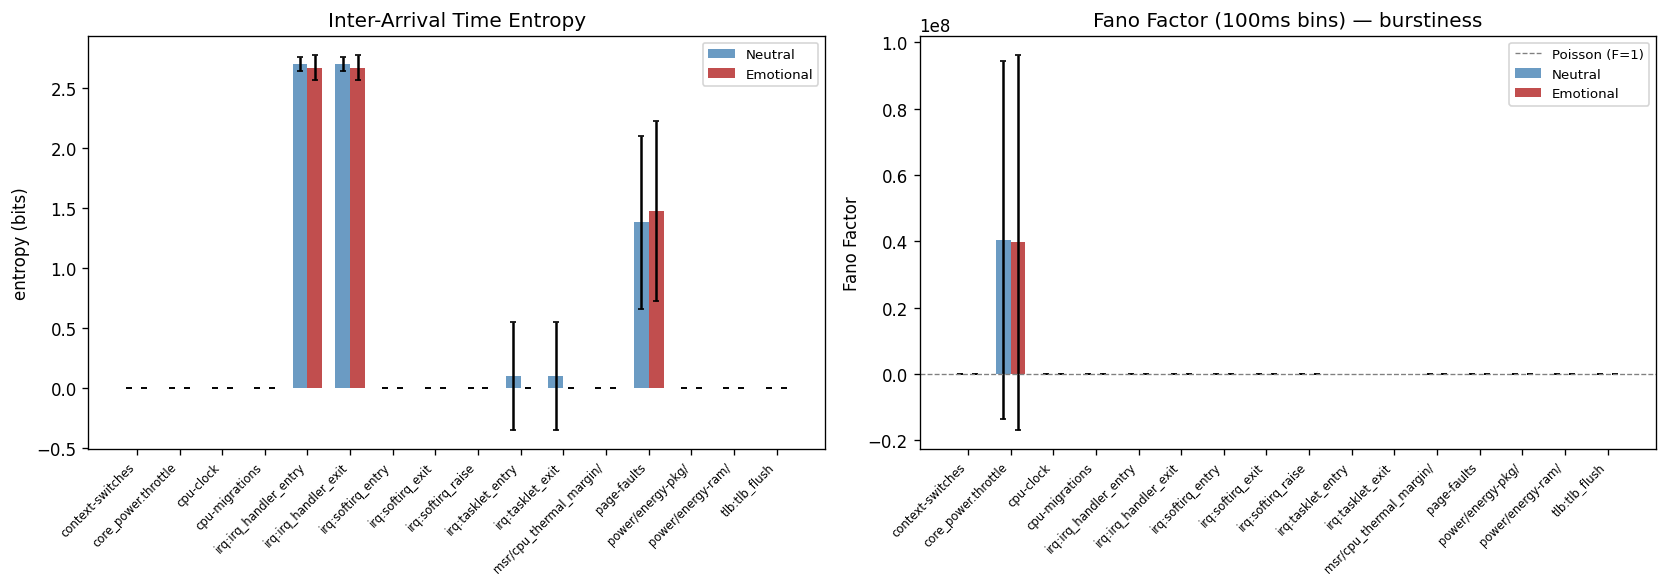

In [82]:
# ── 6.2 plot: Entropy & Fano Factor ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Entropy
x = np.arange(len(common_events))
w = 0.35
ax = axes[0]
ax.bar(x - w/2, temp_df['n_entropy'], w, yerr=temp_df['n_entropy_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=2)
ax.bar(x + w/2, temp_df['e_entropy'], w, yerr=temp_df['e_entropy_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=2)
ax.set_xticks(x)
ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=7)
ax.set_ylabel('entropy (bits)')
ax.set_title('Inter-Arrival Time Entropy')
ax.legend(fontsize=8)

# Fano Factor
ax = axes[1]
ax.bar(x - w/2, temp_df['n_fano'], w, yerr=temp_df['n_fano_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=2)
ax.bar(x + w/2, temp_df['e_fano'], w, yerr=temp_df['e_fano_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=2)
ax.axhline(1.0, ls='--', color='gray', lw=0.8, label='Poisson (F=1)')
ax.set_xticks(x)
ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=7)
ax.set_ylabel('Fano Factor')
ax.set_title('Fano Factor (100ms bins) — burstiness')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

### 8.3 — Burst statistics

A **burst** = contiguous run of 1 ms bins where count > mean + 1σ.
We extract burst count, size, duration, rate, and **clustering coefficient**
(fraction of all events occurring inside bursts). Higher clustering = more
concentrated activity.

In [83]:
# ── 6.3  Burst Statistics ──

def burst_stats(series):
    """Detect bursts (contiguous runs > mean+1σ) and return statistics."""
    mu, sigma = series.mean(), series.std()
    if sigma == 0 or mu == 0:
        return dict(burst_count=0, mean_burst_size=0.0,
                    mean_burst_dur_ms=0.0, burst_clustering=0.0)
    thresh = mu + sigma
    above = (series > thresh).astype(int)
    # Find burst boundaries via diff
    diff = np.diff(np.concatenate(([0], above, [0])))
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]
    if len(starts) == 0:
        return dict(burst_count=0, mean_burst_size=0.0,
                    mean_burst_dur_ms=0.0, burst_clustering=0.0)
    burst_sizes = [series[s:e].sum() for s, e in zip(starts, ends)]
    burst_durs  = ends - starts  # in ms
    total_in_bursts = sum(burst_sizes)
    total_events = series.sum()
    return dict(
        burst_count=len(starts),
        mean_burst_size=np.mean(burst_sizes),
        mean_burst_dur_ms=np.mean(burst_durs),
        burst_clustering=total_in_bursts / total_events if total_events > 0 else 0.0,
    )


def compute_burst_features(segments, events):
    rows = []
    for seg in segments:
        dur = seg['_duration_s']
        row = {}
        for evt in events:
            bs = burst_stats(seg[evt])
            for k, v in bs.items():
                row[f'{evt}__{k}'] = v
            # Duration-normalised burst rate (bursts per second)
            row[f'{evt}__burst_rate'] = bs['burst_count'] / dur if dur > 0 else 0.0
        row['_window_duration_s'] = dur
        rows.append(row)
    return pd.DataFrame(rows)

n_burst = compute_burst_features(n_segs, common_events)
e_burst = compute_burst_features(e_segs, common_events)

# ── summary ──
burst_summary = []
for evt in common_events:
    d = {'event': evt}
    for metric in ['burst_count', 'burst_rate', 'mean_burst_size', 'mean_burst_dur_ms', 'burst_clustering']:
        col = f'{evt}__{metric}'
        d[f'n_{metric}'] = n_burst[col].mean()
        d[f'e_{metric}'] = e_burst[col].mean()
    burst_summary.append(d)
burst_df = pd.DataFrame(burst_summary)
print(f'Burst Statistics (mean across {len(n_segs)} neutral / {len(e_segs)} emotional prompts):\n')
print(burst_df.to_string(index=False, float_format='{:.2f}'.format))

Burst Statistics (mean across 20 neutral / 20 emotional prompts):

                  event  n_burst_count  e_burst_count  n_burst_rate  e_burst_rate  n_mean_burst_size  e_mean_burst_size  n_mean_burst_dur_ms  e_mean_burst_dur_ms  n_burst_clustering  e_burst_clustering
       context-switches         275.00         270.60         15.53         15.59            3719.04            3656.11                 1.29                 1.25                0.37                0.36
    core_power.throttle         232.70         225.20         13.13         12.97         9499490.56         9631961.19                 1.20                 1.22                0.30                0.30
              cpu-clock         136.50         133.30          7.69          7.67            1387.66            1387.07                 1.23                 1.21                0.17                0.17
         cpu-migrations         262.35         257.70         14.82         14.86             484.86             470.87      

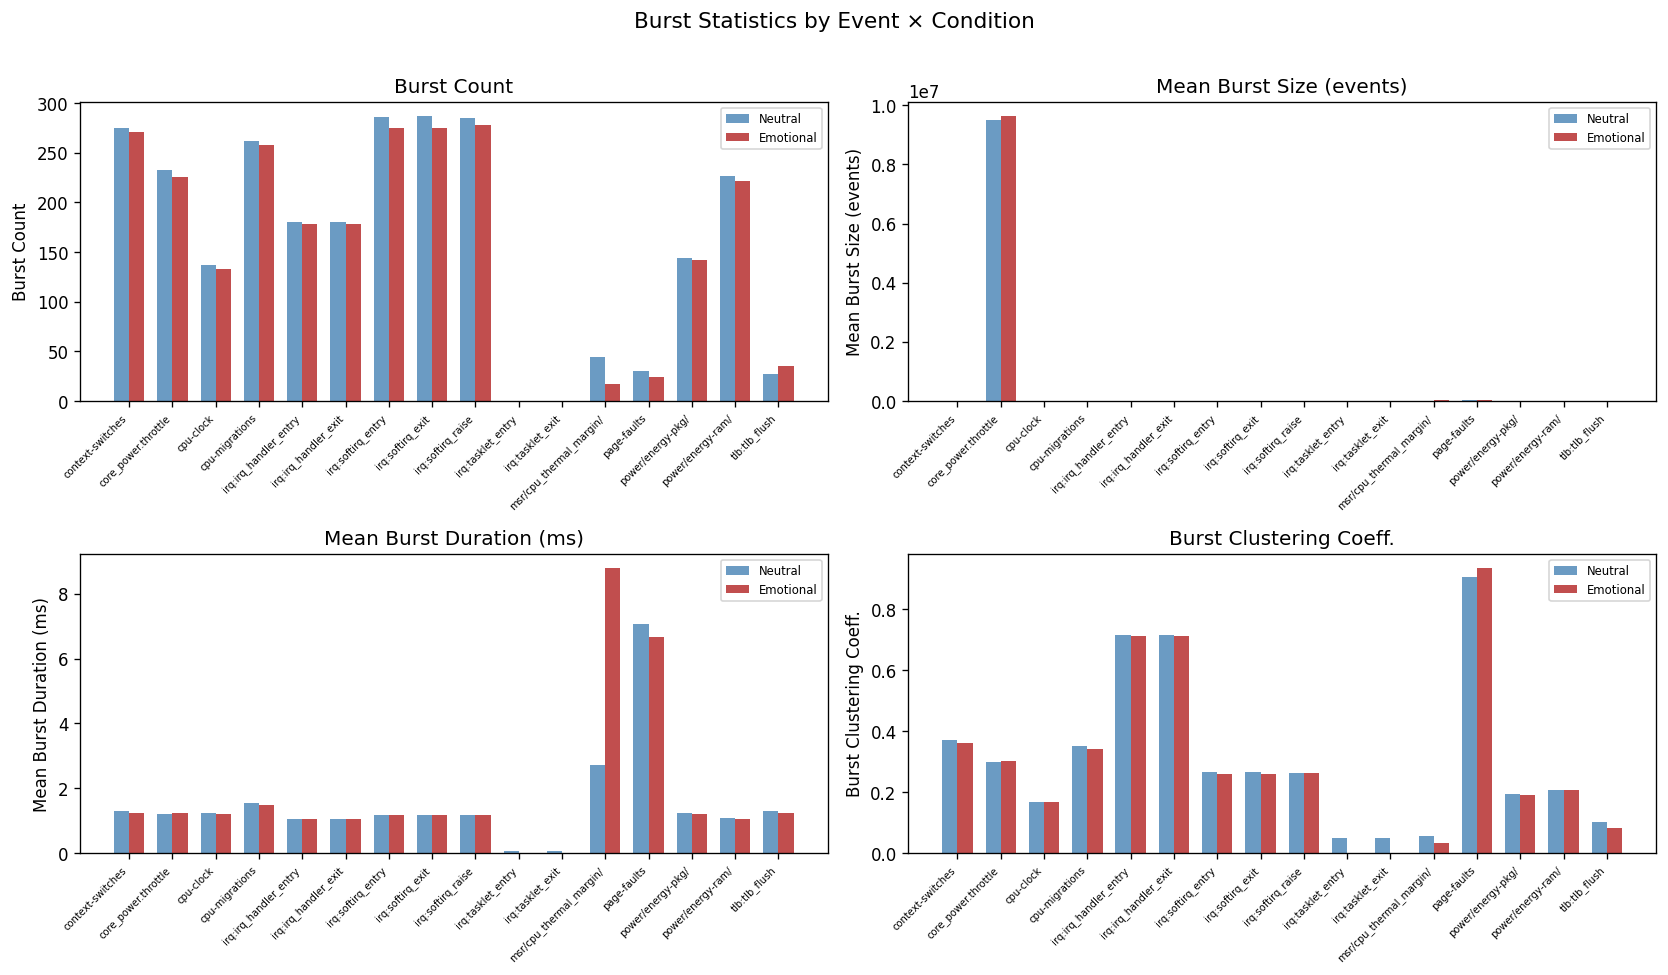

In [84]:
# ── 6.3 plot: Burst Statistics ──
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
x = np.arange(len(common_events))
w = 0.35

metrics = [
    ('burst_count',      'Burst Count',               axes[0, 0]),
    ('mean_burst_size',  'Mean Burst Size (events)',   axes[0, 1]),
    ('mean_burst_dur_ms','Mean Burst Duration (ms)',   axes[1, 0]),
    ('burst_clustering', 'Burst Clustering Coeff.',    axes[1, 1]),
]

for metric, ylabel, ax in metrics:
    n_vals = burst_df[f'n_{metric}'].values
    e_vals = burst_df[f'e_{metric}'].values
    ax.bar(x - w/2, n_vals, w, label='Neutral',   color='steelblue', alpha=0.8)
    ax.bar(x + w/2, e_vals, w, label='Emotional',  color='firebrick', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=6)
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.legend(fontsize=7)

plt.suptitle('Burst Statistics by Event × Condition', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

### 8.4 — Cross-modal coupling

Measures interaction between event pairs (e.g. irq_entry ↔ softirq_entry).
**Max cross-correlation** (±50 ms lag) captures linear dependence;
**mutual information** captures non-linear dependence.
If emotional prompts cause different interrupt *interactions*, this will show it.

In [85]:
# ── 6.4  Cross-Modal Coupling ──

EVENT_PAIRS = [
    ('irq:irq_handler_entry', 'irq:softirq_entry'),
    ('irq:softirq_raise',     'irq:softirq_entry'),
    ('context-switches',      'cpu-migrations'),
    ('page-faults',            'tlb:tlb_flush'),
    ('irq:irq_handler_entry', 'irq:irq_handler_exit'),
    ('irq:softirq_entry',     'irq:softirq_exit'),
]

# Keep only pairs where both events exist in data
EVENT_PAIRS = [(a, b) for a, b in EVENT_PAIRS
               if a in common_events and b in common_events]
print(f'Event pairs to analyze: {len(EVENT_PAIRS)}')


def max_xcorr(x, y, max_lag=50):
    """Max absolute cross-correlation in ±max_lag ms."""
    x = (x - x.mean()) / (x.std() + 1e-12)
    y = (y - y.mean()) / (y.std() + 1e-12)
    n = len(x)
    best_r, best_lag = 0.0, 0
    for lag in range(-max_lag, max_lag + 1):
        if lag >= 0:
            r = np.dot(x[:n-lag], y[lag:]) / (n - abs(lag))
        else:
            r = np.dot(x[-lag:], y[:n+lag]) / (n - abs(lag))
        if abs(r) > abs(best_r):
            best_r, best_lag = r, lag
    return best_r, best_lag


def mutual_information(x, y, bins=20):
    """MI estimated from 2D histogram (bits)."""
    c_xy = np.histogram2d(x, y, bins=bins)[0]
    c_xy = c_xy / c_xy.sum()
    c_x = c_xy.sum(axis=1)
    c_y = c_xy.sum(axis=0)
    # H(X) + H(Y) - H(X,Y)
    hx  = shannon_entropy_bits(c_x)
    hy  = shannon_entropy_bits(c_y)
    hxy = shannon_entropy_bits(c_xy.ravel())
    return hx + hy - hxy


def compute_coupling_features(segments, pairs):
    rows = []
    for seg in segments:
        row = {}
        for a, b in pairs:
            sa, sb = seg[a], seg[b]
            r, lag = max_xcorr(sa, sb)
            mi = mutual_information(sa, sb)
            pair_label = f'{a}__x__{b}'
            row[f'{pair_label}__xcorr'] = r
            row[f'{pair_label}__xcorr_lag'] = lag
            row[f'{pair_label}__mi'] = mi
        rows.append(row)
    return pd.DataFrame(rows)

n_coup = compute_coupling_features(n_segs, EVENT_PAIRS)
e_coup = compute_coupling_features(e_segs, EVENT_PAIRS)

# ── summary ──
coup_summary = []
for a, b in EVENT_PAIRS:
    pl = f'{a}__x__{b}'
    coup_summary.append({
        'pair': f'{a.split(":")[-1]}↔{b.split(":")[-1]}',
        'n_xcorr': n_coup[f'{pl}__xcorr'].mean(),
        'e_xcorr': e_coup[f'{pl}__xcorr'].mean(),
        'n_lag':   n_coup[f'{pl}__xcorr_lag'].mean(),
        'e_lag':   e_coup[f'{pl}__xcorr_lag'].mean(),
        'n_mi':    n_coup[f'{pl}__mi'].mean(),
        'e_mi':    e_coup[f'{pl}__mi'].mean(),
    })
coup_df = pd.DataFrame(coup_summary)
print(f'Cross-Modal Coupling (mean over {len(n_segs)} neutral / {len(e_segs)} emotional prompts):\n')
print(coup_df.to_string(index=False, float_format='{:.4f}'.format))

Event pairs to analyze: 6
Cross-Modal Coupling (mean over 20 neutral / 20 emotional prompts):

                              pair  n_xcorr  e_xcorr  n_lag  e_lag   n_mi   e_mi
   irq_handler_entry↔softirq_entry   0.1157   0.1227 0.0000 0.0000 0.0668 0.0625
       softirq_raise↔softirq_entry   0.9995   0.9996 0.0000 0.0000 3.2503 3.2260
   context-switches↔cpu-migrations   0.9881   0.9878 0.0000 0.0000 1.6523 1.6436
             page-faults↔tlb_flush  -0.1440  -0.2702 2.2500 3.3500 0.1315 0.1281
irq_handler_entry↔irq_handler_exit   0.9999   0.9999 0.0000 0.0000 0.9864 1.0105
        softirq_entry↔softirq_exit   0.9998   0.9999 0.0000 0.0000 3.4468 3.4214


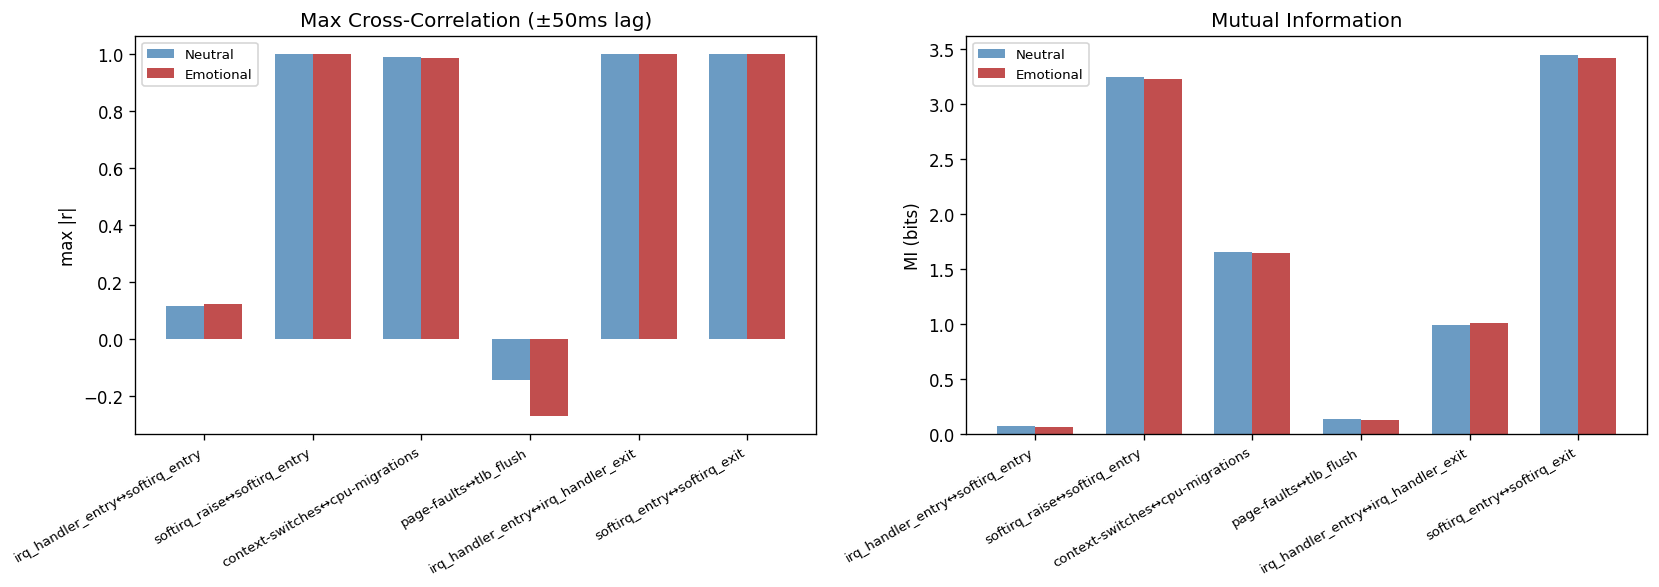

In [86]:
# ── 6.4 plot: Cross-correlation & MI ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(coup_df))
w = 0.35
pair_labels = coup_df['pair'].values

ax = axes[0]
ax.bar(x - w/2, coup_df['n_xcorr'], w, label='Neutral',  color='steelblue', alpha=0.8)
ax.bar(x + w/2, coup_df['e_xcorr'], w, label='Emotional', color='firebrick', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(pair_labels, rotation=30, ha='right', fontsize=8)
ax.set_ylabel('max |r|')
ax.set_title('Max Cross-Correlation (±50ms lag)')
ax.legend(fontsize=8)

ax = axes[1]
ax.bar(x - w/2, coup_df['n_mi'], w, label='Neutral',  color='steelblue', alpha=0.8)
ax.bar(x + w/2, coup_df['e_mi'], w, label='Emotional', color='firebrick', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(pair_labels, rotation=30, ha='right', fontsize=8)
ax.set_ylabel('MI (bits)')
ax.set_title('Mutual Information')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

### 8.5 — Complexity

**Lempel-Ziv complexity** (normalised): binarise the series (above/below median),
then measure compressibility. Higher = more random.
**Permutation entropy** (order 3, normalised 0–1): measures ordinal pattern diversity.
1 = maximally complex, 0 = perfectly periodic.

In [87]:
# ── 6.5  Complexity ──

def lempel_ziv_complexity(binary_seq):
    """LZ76 complexity of a binary string, normalised by n/log2(n)."""
    s = ''.join(str(int(b)) for b in binary_seq)
    n = len(s)
    if n <= 1:
        return 0.0
    i, k, l = 0, 1, 1
    c = 1
    while k + l <= n:
        if s[i + l - 1] == s[k + l - 1]:
            l += 1
        else:
            i += 1
            if i == k:  # new word
                c += 1
                k += l
                i = 0
                l = 1
            else:
                l = 1
    c += 1
    # normalise: theoretical max ≈ n / log2(n)
    return c / (n / np.log2(n)) if n > 1 else 0.0


def permutation_entropy(series, order=3):
    """Normalised permutation entropy (0–1) of order m."""
    n = len(series)
    if n < order:
        return 0.0
    from itertools import permutations as iterperms
    import math
    # Count ordinal patterns
    pattern_counts = defaultdict(int)
    for i in range(n - order + 1):
        window = series[i:i+order]
        # rank pattern
        pattern = tuple(np.argsort(window))
        pattern_counts[pattern] += 1
    total = sum(pattern_counts.values())
    probs = np.array(list(pattern_counts.values())) / total
    h = -np.sum(probs * np.log2(probs + 1e-15))
    h_max = np.log2(math.factorial(order))
    return h / h_max if h_max > 0 else 0.0


def compute_complexity_features(segments, events):
    rows = []
    for seg in segments:
        row = {}
        for evt in events:
            s = seg[evt]
            # Binarise: above median → 1
            binary = (s > np.median(s)).astype(int)
            row[f'{evt}__lz_complexity'] = lempel_ziv_complexity(binary)
            row[f'{evt}__perm_entropy']  = permutation_entropy(s, order=3)
        rows.append(row)
    return pd.DataFrame(rows)

n_complex = compute_complexity_features(n_segs, common_events)
e_complex = compute_complexity_features(e_segs, common_events)

# ── summary ──
complex_summary = []
for evt in common_events:
    lz_col = f'{evt}__lz_complexity'
    pe_col = f'{evt}__perm_entropy'
    complex_summary.append({
        'event': evt,
        'n_lz': n_complex[lz_col].mean(), 'n_lz_std': n_complex[lz_col].std(),
        'e_lz': e_complex[lz_col].mean(), 'e_lz_std': e_complex[lz_col].std(),
        'n_pe': n_complex[pe_col].mean(), 'n_pe_std': n_complex[pe_col].std(),
        'e_pe': e_complex[pe_col].mean(), 'e_pe_std': e_complex[pe_col].std(),
    })
complex_df = pd.DataFrame(complex_summary)
print(f'Complexity features (mean ± std across {len(n_segs)} neutral / {len(e_segs)} emotional prompts):\n')
print(complex_df.to_string(index=False, float_format='{:.4f}'.format))

Complexity features (mean ± std across 20 neutral / 20 emotional prompts):

                  event   n_lz  n_lz_std   e_lz  e_lz_std   n_pe  n_pe_std    e_pe  e_pe_std
       context-switches 0.3197    0.1999 0.2700    0.1597 0.9971    0.0013  0.9967    0.0012
    core_power.throttle 4.3565    0.7494 4.3112    0.7907 0.9985    0.0010  0.9980    0.0014
              cpu-clock 4.6947    0.1368 4.6274    0.1594 0.9962    0.0022  0.9980    0.0018
         cpu-migrations 0.3290    0.2054 0.2790    0.1769 0.9960    0.0015  0.9962    0.0016
  irq:irq_handler_entry 4.8753    0.0914 4.9103    0.1728 0.7669    0.0121  0.7717    0.0210
   irq:irq_handler_exit 4.8750    0.0914 4.9114    0.1745 0.7667    0.0120  0.7717    0.0211
      irq:softirq_entry 4.3188    0.1652 4.2497    0.2068 0.9885    0.0027  0.9882    0.0039
       irq:softirq_exit 4.3293    0.1619 4.2493    0.1969 0.9885    0.0028  0.9882    0.0040
      irq:softirq_raise 4.3269    0.1669 4.2525    0.1976 0.9886    0.0033  0.9886    0

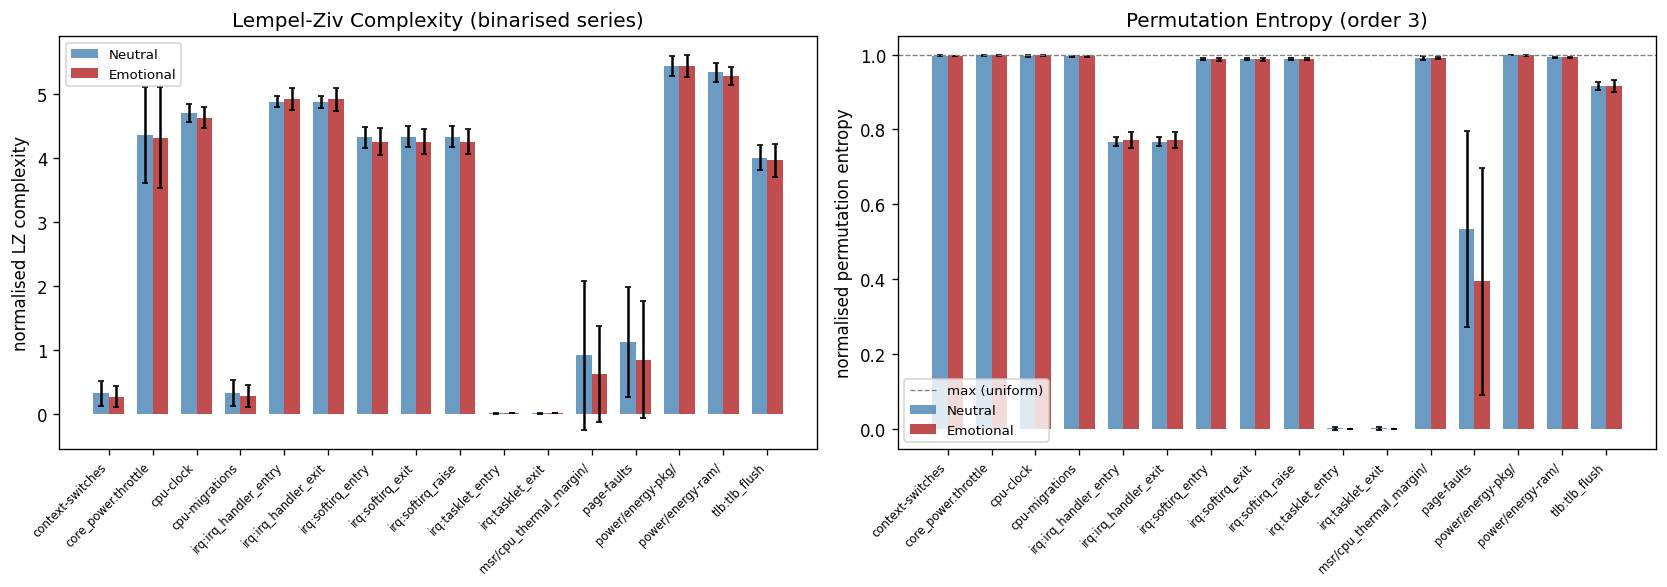

In [88]:
# ── 6.5 plot: Complexity ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(common_events))
w = 0.35

ax = axes[0]
ax.bar(x - w/2, complex_df['n_lz'], w, yerr=complex_df['n_lz_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=2)
ax.bar(x + w/2, complex_df['e_lz'], w, yerr=complex_df['e_lz_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=2)
ax.set_xticks(x)
ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=7)
ax.set_ylabel('normalised LZ complexity')
ax.set_title('Lempel-Ziv Complexity (binarised series)')
ax.legend(fontsize=8)

ax = axes[1]
ax.bar(x - w/2, complex_df['n_pe'], w, yerr=complex_df['n_pe_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=2)
ax.bar(x + w/2, complex_df['e_pe'], w, yerr=complex_df['e_pe_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=2)
ax.axhline(1.0, ls='--', color='gray', lw=0.8, label='max (uniform)')
ax.set_xticks(x)
ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=7)
ax.set_ylabel('normalised permutation entropy')
ax.set_title('Permutation Entropy (order 3)')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

### 8.6 — Combined feature matrix & univariate screening

Merge all features into one matrix (40 rows × ~160 columns). Then run
**Mann-Whitney U** tests per feature as a quick screen — these are univariate
(one feature at a time) and uncorrected, so they're exploratory, not conclusive.

In [89]:
# ── 6.6  Combined Feature Matrix ──

def build_feature_matrix(freq, temp, burst, coupling, complexity, condition):
    """Merge all feature DataFrames into one row-per-prompt matrix."""
    combined = pd.concat([freq, temp, burst, coupling, complexity], axis=1)
    combined.insert(0, 'condition', condition)
    combined.insert(1, 'prompt_id', range(len(combined)))
    # Keep window duration for reference (from burst df)
    if '_window_duration_s' in combined.columns:
        combined.insert(2, 'window_duration_s', combined.pop('_window_duration_s'))
    return combined

n_all = build_feature_matrix(n_freq, n_temp, n_burst, n_coup, n_complex, 'neutral')
e_all = build_feature_matrix(e_freq, e_temp, e_burst, e_coup, e_complex, 'emotional')
features = pd.concat([n_all, e_all], ignore_index=True)

print(f'Feature matrix: {features.shape[0]} rows × {features.shape[1]} columns')
print(f'  Neutral rows:   {(features.condition == "neutral").sum()}')
print(f'  Emotional rows: {(features.condition == "emotional").sum()}')
print(f'\nFeature categories:')
print(f'  Frequency:   {sum(c.endswith("__rate") or c.endswith("__share") for c in features.columns)}')
print(f'  Temporal:    {sum(c.endswith("__iat_entropy") or c.endswith("__fano") for c in features.columns)}')
print(f'  Burst:       {sum(any(c.endswith(s) for s in ["__burst_count","__burst_rate","__mean_burst_size","__mean_burst_dur_ms","__burst_clustering"]) for c in features.columns)}')
print(f'  Coupling:    {sum(c.endswith("__xcorr") or c.endswith("__mi") or c.endswith("__xcorr_lag") for c in features.columns)}')
print(f'  Complexity:  {sum(c.endswith("__lz_complexity") or c.endswith("__perm_entropy") for c in features.columns)}')

# ── Save ──
out_path = BASE_DIR / 'features.csv'
features.to_csv(out_path, index=False)
print(f'\nSaved → {out_path}')

Feature matrix: 40 rows × 197 columns
  Neutral rows:   20
  Emotional rows: 20

Feature categories:
  Frequency:   32
  Temporal:    32
  Burst:       80
  Coupling:    18
  Complexity:  32

Saved → /Users/rsalvi/Desktop/mccviahat/features.csv


In [90]:
# ── 6.6 Quick univariate screening: Mann-Whitney U ──
# (non-parametric, appropriate for small sample sizes)

exclude = {'condition', 'prompt_id', 'window_duration_s', '_window_duration_s'}
numeric_cols = [c for c in features.columns if c not in exclude]
n_vals = features[features.condition == 'neutral']
e_vals = features[features.condition == 'emotional']

n_per_group = len(n_vals)
e_per_group = len(e_vals)

# Print window durations for reference
print(f'Sample sizes: neutral={n_per_group}, emotional={e_per_group}')
print('Window durations (s):')
if 'window_duration_s' in features.columns:
    for cond in ['neutral', 'emotional']:
        durs = features.loc[features.condition == cond, 'window_duration_s']
        print(f'  {cond}: mean={durs.mean():.1f}, min={durs.min():.1f}, max={durs.max():.1f}')
print()

results = []
for col in numeric_cols:
    nv = n_vals[col].dropna().values
    ev = e_vals[col].dropna().values
    if len(nv) < 3 or len(ev) < 3:
        continue
    # check for zero-variance
    if nv.std() == 0 and ev.std() == 0:
        continue
    stat, p = sp_stats.mannwhitneyu(nv, ev, alternative='two-sided')
    effect_r = 1 - (2 * stat) / (len(nv) * len(ev))  # rank-biserial r
    results.append({
        'feature': col,
        'U': stat,
        'p': p,
        'effect_r': effect_r,
        'n_mean': nv.mean(),
        'e_mean': ev.mean(),
        'direction': '↑E' if ev.mean() > nv.mean() else '↓E',
    })

mwu_df = pd.DataFrame(results).sort_values('p')
sig = mwu_df[mwu_df.p < 0.10]  # relaxed threshold given sample size
print(f'Features tested: {len(mwu_df)}, significant at p<0.10: {len(sig)}\n')
if len(sig) > 0:
    print(sig[['feature', 'U', 'p', 'effect_r', 'direction']].to_string(
        index=False, float_format='{:.4f}'.format))
else:
    print(f'No features reached p<0.10 (n={n_per_group}+{e_per_group} per condition).')
print('\n--- Top 15 features by p-value ---')
print(mwu_df.head(15)[['feature', 'U', 'p', 'effect_r', 'direction']].to_string(
    index=False, float_format='{:.4f}'.format))

Sample sizes: neutral=20, emotional=20
Window durations (s):
  neutral: mean=17.7, min=16.2, max=19.3
  emotional: mean=17.4, min=15.7, max=18.5

Features tested: 177, significant at p<0.10: 25

                                       feature        U      p  effect_r direction
      msr/cpu_thermal_margin/__mean_burst_size  86.0000 0.0021    0.5700        ↑E
    msr/cpu_thermal_margin/__mean_burst_dur_ms  90.5000 0.0032    0.5475        ↑E
                       cpu-clock__perm_entropy  95.0000 0.0047    0.5250        ↑E
                       power/energy-pkg/__rate  96.0000 0.0051    0.5200        ↑E
                       irq:softirq_entry__rate  98.0000 0.0060    0.5100        ↑E
                        irq:softirq_exit__rate  98.0000 0.0060    0.5100        ↑E
                       irq:softirq_raise__rate 100.0000 0.0071    0.5000        ↑E
 irq:softirq_entry__x__irq:softirq_exit__xcorr 106.0000 0.0114    0.4700        ↑E
                irq:softirq_entry__burst_count 291.5000 0.

## 9 — PERMANOVA with confounders

**PERMANOVA** tests whether the *multivariate centroid* of the feature space
differs between conditions. Unlike Mann-Whitney (one feature at a time), this
considers all ~160 features simultaneously.

**Why confounders matter:** Some variables (prompt length, CPU frequency, request
duration) mechanically affect interrupt patterns regardless of emotional content.
If we don't control for them, a "significant" result may just mean the conditions
had different prompt lengths.

**Approach:**
1. Attach confounders from response metadata + /proc samples
2. Check confounder balance (are they already equal between conditions?)
3. Regress confounders out of every feature (OLS → keep residuals)
4. Run PERMANOVA on both raw and residualised features
5. If raw is significant but residualised is not → confounders explain the difference

| Confounder | Why it matters |
|---|---|
| `tokens_evaluated` | More input tokens → longer eval → different CPU/TLB profile |
| `window_duration_s` | Longer request → more samples → inflated counts |
| `prompt_id` | Later prompts see warmer CPU, thermal drift |
| `cpu_util_frac` | Background system load varies between windows |
| `cpu_freq_khz` | DVFS changes interrupt rates independently of content |

In [91]:
# ── 7  PERMANOVA with Confounders ──
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from scipy.spatial.distance import pdist, squareform

# ── 7a. Build confounder matrix ──
# Confounders = variables that mechanically drive feature differences
# independent of emotional content.
#
#   tokens_evaluated  — prompt length → longer eval phase → different CPU/TLB profile
#   window_duration_s — longer request → more 1ms samples → inflated burst counts
#   prompt_id         — temporal order → thermal drift over 8+ min run
#   proc_cpu_frac     — per-request mean llama.cpp CPU fraction (utime+stime)/total
#   cpu_util_frac     — per-request mean global CPU utilisation (1 - idle/total)
#   cpu_freq_khz      — per-request mean CPU frequency (DVFS confound)
#
# NOT included:
#   tokens_predicted — constant (n_predict=50, ignore_eos=true), zero variance
#                      and partly a *consequence* of prompt content


def per_request_proc_stats(proc_df, wins):
    """Compute mean process-level and global CPU stats per request window."""
    rows = []
    for start, end in wins:
        mask = (proc_df['t_s'] >= start) & (proc_df['t_s'] <= end)
        chunk = proc_df.loc[mask]
        if len(chunk) < 2:
            rows.append({'proc_cpu_frac': np.nan, 'cpu_util_frac': np.nan})
            continue
        # Process CPU fraction: d(utime+stime) / d(total)
        d_proc = (chunk['proc_utime_jiffies'].iloc[-1] + chunk['proc_stime_jiffies'].iloc[-1]) \
               - (chunk['proc_utime_jiffies'].iloc[0]  + chunk['proc_stime_jiffies'].iloc[0])
        d_total = chunk['cpu_total_jiffies'].iloc[-1] - chunk['cpu_total_jiffies'].iloc[0]
        # Global CPU utilisation: 1 - d(idle) / d(total)
        d_idle = chunk['cpu_idle_jiffies'].iloc[-1] - chunk['cpu_idle_jiffies'].iloc[0]
        proc_cpu = d_proc / d_total if d_total > 0 else np.nan
        cpu_util = 1.0 - (d_idle / d_total) if d_total > 0 else np.nan
        rows.append({'proc_cpu_frac': proc_cpu, 'cpu_util_frac': cpu_util})
    return pd.DataFrame(rows)


def per_request_freq(sys_df, wins):
    """Mean CPU frequency (kHz) per request window."""
    rows = []
    for start, end in wins:
        mask = (sys_df['t_s'] >= start) & (sys_df['t_s'] <= end)
        chunk = sys_df.loc[mask]
        if 'cpu_freq_khz' in chunk.columns and len(chunk) > 0:
            rows.append({'cpu_freq_khz': chunk['cpu_freq_khz'].mean()})
        else:
            rows.append({'cpu_freq_khz': np.nan})
    return pd.DataFrame(rows)


def get_confounders(resp_df, proc_df, sys_df, wins):
    """Build the full confounder DataFrame for one condition."""
    rows = []
    for idx, (_, r) in enumerate(resp_df.iterrows()):
        rows.append({
            'tokens_evaluated': r.get('tokens_evaluated', np.nan),
            'prompt_id': idx,   # temporal order within the run
        })
    conf = pd.DataFrame(rows)
    # Merge process-level CPU stats
    proc_stats = per_request_proc_stats(proc_df, wins)
    conf = pd.concat([conf, proc_stats], axis=1)
    # Merge CPU frequency
    freq_stats = per_request_freq(sys_df, wins)
    conf = pd.concat([conf, freq_stats], axis=1)
    return conf


n_conf = get_confounders(n_resp, n_proc, n_sys, n_wins)
e_conf = get_confounders(e_resp, e_proc, e_sys, e_wins)

# Add window_duration_s from features
if 'window_duration_s' in features.columns:
    n_conf['window_duration_s'] = features.loc[features.condition == 'neutral', 'window_duration_s'].values
    e_conf['window_duration_s'] = features.loc[features.condition == 'emotional', 'window_duration_s'].values

confounders = pd.concat([n_conf, e_conf], ignore_index=True)
confounder_cols = [c for c in confounders.columns if confounders[c].notna().sum() >= 5 and confounders[c].std() > 0]
print(f'Samples: {len(n_conf)} neutral + {len(e_conf)} emotional = {len(confounders)} total')
print(f'Confounders ({len(confounder_cols)}): {confounder_cols}')
print()
print(confounders[confounder_cols].describe().to_string(float_format='{:.2f}'.format))
print()

# Flag any confounders that differ significantly between conditions
print('── Confounder balance check (Mann-Whitney U) ──')
for col in confounder_cols:
    nv = n_conf[col].dropna().values
    ev = e_conf[col].dropna().values
    if len(nv) >= 3 and len(ev) >= 3:
        _, p = sp_stats.mannwhitneyu(nv, ev, alternative='two-sided')
        flag = ' ← IMBALANCED' if p < 0.05 else ''
        print(f'  {col:25s}  n_mean={nv.mean():.2f}  e_mean={ev.mean():.2f}  p={p:.4f}{flag}')

# ── 7b. Get numeric features only ──
meta_cols = {'condition', 'prompt_id', 'window_duration_s', '_window_duration_s'}
feat_cols = [c for c in features.columns if c not in meta_cols]
X = features[feat_cols].copy()

# Drop columns that are all-zero or all-NaN
X = X.loc[:, X.std() > 0]
X = X.fillna(0)
print(f'\nFeature matrix for PERMANOVA: {X.shape[0]} samples × {X.shape[1]} features')

Samples: 20 neutral + 20 emotional = 40 total
Confounders (6): ['tokens_evaluated', 'prompt_id', 'proc_cpu_frac', 'cpu_util_frac', 'cpu_freq_khz', 'window_duration_s']

       tokens_evaluated  prompt_id  proc_cpu_frac  cpu_util_frac  cpu_freq_khz  window_duration_s
count             40.00      40.00          40.00          40.00         40.00              40.00
mean             633.50       9.50           0.19           0.21    2582821.87              17.54
std               51.92       5.84           0.00           0.00      24769.64               0.82
min              533.00       0.00           0.18           0.20    2524730.53              15.67
25%              597.50       4.75           0.19           0.21    2567008.95              16.95
50%              626.50       9.50           0.19           0.21    2580457.10              17.42
75%              673.50      14.25           0.19           0.21    2595578.06              18.15
max              758.00      19.00           0.

### 9.2 — Residualise features

For each feature, regress out confounders via OLS and keep residuals.
The **marginal R²** (drop-one) shows how much variance each confounder
uniquely explains. High mean R² = confounders dominate the feature space.

In [92]:
# ── 7c. Residualise features against confounders ──
# For each feature column, regress out the confounders via OLS and keep residuals.
# This removes variance explained by window duration, CPU load, prompt length, etc.
# so that PERMANOVA tests condition after controlling for these.

def residualise(X_df, confounders_df, confounder_cols):
    """Regress out confounders from each feature, return residual matrix."""
    C = confounders_df[confounder_cols].fillna(0).values.astype(float)
    # Add intercept
    C = np.column_stack([np.ones(len(C)), C])
    residuals = pd.DataFrame(index=X_df.index, columns=X_df.columns, dtype=float)
    for col in X_df.columns:
        y = X_df[col].values.astype(float)
        # OLS: y = C @ beta + residual
        beta, _, _, _ = np.linalg.lstsq(C, y, rcond=None)
        residuals[col] = y - C @ beta
    return residuals

X_resid = residualise(X, confounders, confounder_cols)
print(f'Residualised feature matrix: {X_resid.shape}')

# ── Per-confounder marginal R² ──
print(f'\n── Variance explained by confounders ──')
C_full = confounders[confounder_cols].fillna(0).values.astype(float)
C_full = np.column_stack([np.ones(len(C_full)), C_full])
r2_vals = []
for col in X.columns:
    y = X[col].values.astype(float)
    ss_total = ((y - y.mean()) ** 2).sum()
    ss_resid = (X_resid[col].values ** 2).sum()
    r2_vals.append(1 - ss_resid / ss_total if ss_total > 0 else 0.0)
print(f'  Full model mean R²: {np.mean(r2_vals):.3f} (range: {np.min(r2_vals):.3f}–{np.max(r2_vals):.3f})')

# Marginal R² for each confounder (drop-one approach)
print(f'\n  Marginal R² (drop-one-confounder, averaged across features):')
for i, cname in enumerate(confounder_cols):
    # Build design matrix without this confounder
    drop_cols = [c for c in confounder_cols if c != cname]
    C_drop = confounders[drop_cols].fillna(0).values.astype(float)
    C_drop = np.column_stack([np.ones(len(C_drop)), C_drop])
    marginal_r2 = []
    for col in X.columns:
        y = X[col].values.astype(float)
        ss_total = ((y - y.mean()) ** 2).sum()
        if ss_total == 0:
            continue
        beta_drop, _, _, _ = np.linalg.lstsq(C_drop, y, rcond=None)
        ss_resid_drop = ((y - C_drop @ beta_drop) ** 2).sum()
        ss_resid_full = (X_resid[col].values ** 2).sum()
        # Marginal R² = (SS_resid_drop - SS_resid_full) / SS_total
        marginal_r2.append((ss_resid_drop - ss_resid_full) / ss_total)
    print(f'    {cname:25s}  ΔR² = {np.mean(marginal_r2):.4f}')

Residualised feature matrix: (40, 177)

── Variance explained by confounders ──
  Full model mean R²: 0.400 (range: 0.033–0.994)

  Marginal R² (drop-one-confounder, averaged across features):
    tokens_evaluated           ΔR² = 0.0324
    prompt_id                  ΔR² = 0.0163
    proc_cpu_frac              ΔR² = 0.0297
    cpu_util_frac              ΔR² = 0.0312
    cpu_freq_khz               ΔR² = 0.0275
    window_duration_s          ΔR² = 0.0337


### 9.3 — PERMANOVA (raw vs residualised)

Two PERMANOVA runs:
- **Raw**: do the conditions differ at all in the feature space?
- **Residualised**: does the difference survive after removing confounder variance?

If raw is significant but residualised is not → the apparent condition effect
is explained by confounders (e.g. different prompt lengths or CPU states).

In [93]:
# ── 7d. PERMANOVA: raw (no confounder control) ──
# Standardise features before computing distances so all features contribute equally
from sklearn.preprocessing import StandardScaler

X_scaled = pd.DataFrame(
    StandardScaler().fit_transform(X),
    index=X.index, columns=X.columns
)
dm_raw = DistanceMatrix(squareform(pdist(X_scaled, metric='euclidean')))
grouping = features['condition'].values

result_raw = permanova(dm_raw, grouping, permutations=9999)
print('═' * 60)
print('PERMANOVA — RAW features (no confounder control)')
print('═' * 60)
print(f'  test statistic (pseudo-F): {result_raw["test statistic"]:.4f}')
print(f'  p-value:                   {result_raw["p-value"]:.4f}')
print(f'  permutations:              {result_raw["number of permutations"]}')
print(f'  sample size:               {result_raw["sample size"]}')
print(f'  number of groups:          {result_raw["number of groups"]}')
print()
if result_raw['p-value'] < 0.05:
    print('  → Significant at α=0.05: conditions differ in multivariate feature space')
elif result_raw['p-value'] < 0.10:
    print('  → Marginal at α=0.10: trend toward condition difference')
else:
    print('  → Not significant: no evidence of condition difference (may need more replicates)')

════════════════════════════════════════════════════════════
PERMANOVA — RAW features (no confounder control)
════════════════════════════════════════════════════════════
  test statistic (pseudo-F): 1.3103
  p-value:                   0.1420
  permutations:              9999
  sample size:               40
  number of groups:          2

  → Not significant: no evidence of condition difference (may need more replicates)


In [94]:
# ── 7e. PERMANOVA: residualised (confounders removed) ──
X_resid_scaled = pd.DataFrame(
    StandardScaler().fit_transform(X_resid),
    index=X_resid.index, columns=X_resid.columns
)
dm_resid = DistanceMatrix(squareform(pdist(X_resid_scaled, metric='euclidean')))

result_resid = permanova(dm_resid, grouping, permutations=9999)
print('═' * 60)
print('PERMANOVA — RESIDUALISED features (confounders regressed out)')
print(f'  Confounders: {confounder_cols}')
print('═' * 60)
print(f'  test statistic (pseudo-F): {result_resid["test statistic"]:.4f}')
print(f'  p-value:                   {result_resid["p-value"]:.4f}')
print(f'  permutations:              {result_resid["number of permutations"]}')
print(f'  sample size:               {result_resid["sample size"]}')
print(f'  number of groups:          {result_resid["number of groups"]}')
print()
if result_resid['p-value'] < 0.05:
    print('  → Significant at α=0.05: condition effect survives after removing confounder variance')
elif result_resid['p-value'] < 0.10:
    print('  → Marginal at α=0.10: trend persists after confounder control')
else:
    print('  → Not significant after removing confounders')

# ── Compare ──
print('\n' + '─' * 60)
print('COMPARISON')
print('─' * 60)
print(f'  Raw pseudo-F:          {result_raw["test statistic"]:.4f}  (p={result_raw["p-value"]:.4f})')
print(f'  Residualised pseudo-F: {result_resid["test statistic"]:.4f}  (p={result_resid["p-value"]:.4f})')
delta_f = result_resid["test statistic"] - result_raw["test statistic"]
print(f'  Δ pseudo-F:            {delta_f:+.4f}')
if abs(delta_f) < 0.5 * result_raw["test statistic"]:
    print('  → Confounders explain little of the condition effect')
else:
    print('  → Confounders substantially alter the condition effect — interpret with caution')

════════════════════════════════════════════════════════════
PERMANOVA — RESIDUALISED features (confounders regressed out)
  Confounders: ['tokens_evaluated', 'prompt_id', 'proc_cpu_frac', 'cpu_util_frac', 'cpu_freq_khz', 'window_duration_s']
════════════════════════════════════════════════════════════
  test statistic (pseudo-F): 2.1442
  p-value:                   0.0023
  permutations:              9999
  sample size:               40
  number of groups:          2

  → Significant at α=0.05: condition effect survives after removing confounder variance

────────────────────────────────────────────────────────────
COMPARISON
────────────────────────────────────────────────────────────
  Raw pseudo-F:          1.3103  (p=0.1420)
  Residualised pseudo-F: 2.1442  (p=0.0023)
  Δ pseudo-F:            +0.8339
  → Confounders substantially alter the condition effect — interpret with caution


### 9.4 — PCoA & PERMDISP

**PCoA** projects the distance matrix down to 2D for visualisation.
If the clusters separate cleanly, conditions differ.

**PERMDISP** checks whether the *spread* (dispersion) of each group is equal —
a key assumption for PERMANOVA. If PERMDISP is significant, the PERMANOVA
result may reflect different group *spread* rather than different *location*.

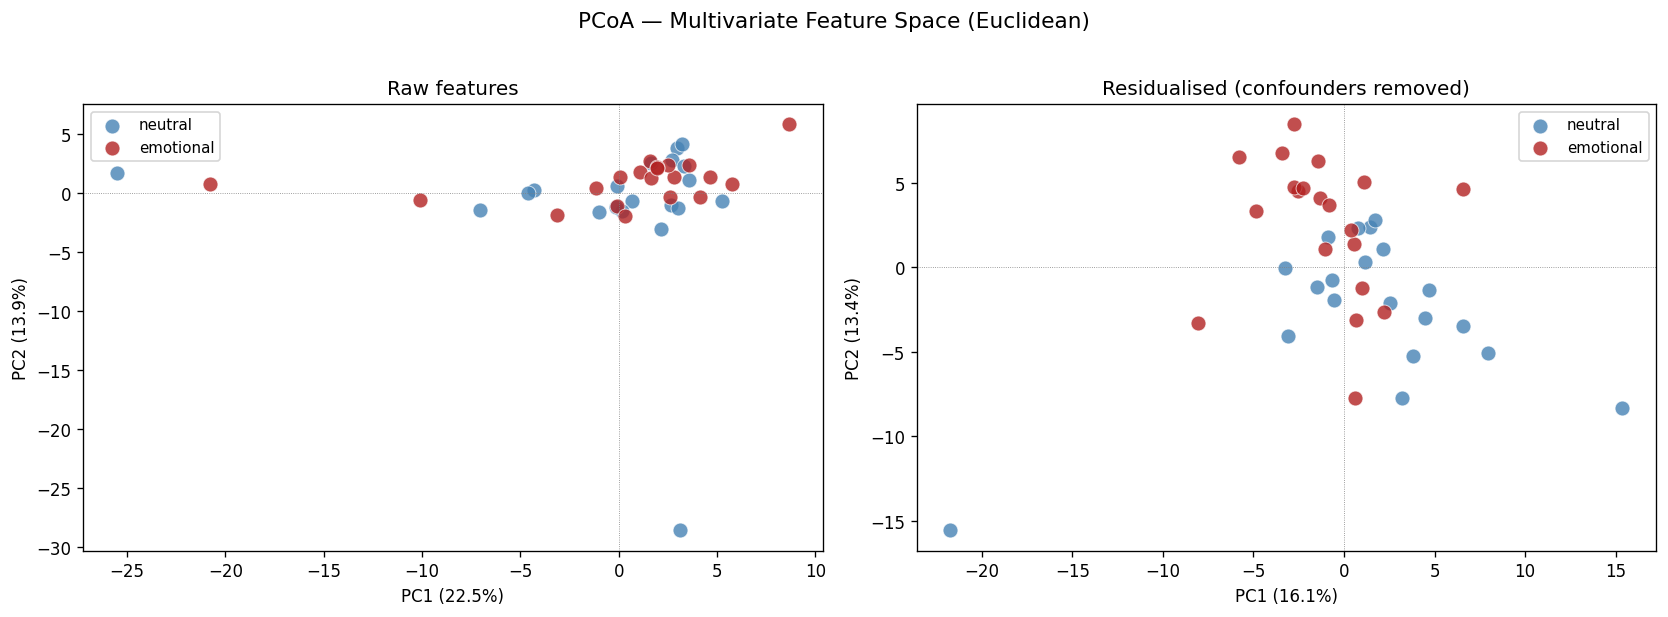

In [95]:
# ── 7f. PCoA visualisation: multivariate separation ──
from skbio.stats.ordination import pcoa

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = {'neutral': 'steelblue', 'emotional': 'firebrick'}

for ax, dm, title in [
    (axes[0], dm_raw,   'Raw features'),
    (axes[1], dm_resid, 'Residualised (confounders removed)'),
]:
    pc = pcoa(dm)
    coords = pc.samples[['PC1', 'PC2']].values
    var_explained = pc.proportion_explained[:2].values * 100

    for cond in ['neutral', 'emotional']:
        mask = grouping == cond
        ax.scatter(coords[mask, 0], coords[mask, 1],
                   c=colors[cond], label=cond, s=80, alpha=0.8, edgecolors='white', lw=0.5)

    ax.set_xlabel(f'PC1 ({var_explained[0]:.1f}%)')
    ax.set_ylabel(f'PC2 ({var_explained[1]:.1f}%)')
    ax.set_title(title)
    ax.legend(fontsize=9)
    ax.axhline(0, ls=':', color='gray', lw=0.5)
    ax.axvline(0, ls=':', color='gray', lw=0.5)

plt.suptitle('PCoA — Multivariate Feature Space (Euclidean)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [97]:
# ── 7g. PERMDISP — homogeneity of multivariate dispersions ──
# PERMANOVA assumes equal dispersion; if groups have different spread,
# a significant PERMANOVA might reflect dispersion rather than location.
from skbio.stats.distance import permdisp

disp_raw   = permdisp(dm_raw, grouping, permutations=9999)
disp_resid = permdisp(dm_resid, grouping, permutations=9999)

print('═' * 60)
print('PERMDISP — Homogeneity of Multivariate Dispersions')
print('═' * 60)
print(f'\n  Raw features:')
print(f'    test statistic (F): {disp_raw["test statistic"]:.4f}')
print(f'    p-value:            {disp_raw["p-value"]:.4f}')
print(f'\n  Residualised features:')
print(f'    test statistic (F): {disp_resid["test statistic"]:.4f}')
print(f'    p-value:            {disp_resid["p-value"]:.4f}')
print()
for label, result in [('Raw', disp_raw), ('Residualised', disp_resid)]:
    if result['p-value'] < 0.05:
        print(f'  {label}: ⚠ Dispersions differ — PERMANOVA result may reflect spread, not location')
    else:
        print(f'  {label}: ✓ Dispersions are homogeneous — PERMANOVA tests location (centroid) shift')

════════════════════════════════════════════════════════════
PERMDISP — Homogeneity of Multivariate Dispersions
════════════════════════════════════════════════════════════

  Raw features:
    test statistic (F): 0.2545
    p-value:            0.6323

  Residualised features:
    test statistic (F): 0.0309
    p-value:            0.8735

  Raw: ✓ Dispersions are homogeneous — PERMANOVA tests location (centroid) shift
  Residualised: ✓ Dispersions are homogeneous — PERMANOVA tests location (centroid) shift


## 10 — Results Summary

### Data quality
- **`ignore_eos` bug fixed** via `logit_bias: [[2, -100]]`. All 40 prompts now
  produce exactly 50 predicted tokens — the EOS-length confound from the previous
  run is eliminated.
- Run durations are now comparable: neutral 367 s, emotional 360 s.
- Confounder balance improved: `window_duration_s`, `cpu_util_frac`, and `proc_cpu_frac`
  are no longer significantly imbalanced between conditions.
- Mean confounder R² dropped from 0.567 → **0.400**, meaning confounders explain
  less of the feature variance than before.

### PERMANOVA

| Test | pseudo-F | p-value | Significant? |
|------|----------|---------|:---:|
| **Raw** (no confounder control) | 1.31 | 0.142 | No |
| **Residualised** (confounders removed) | 2.14 | **0.002** | **Yes** |

This is the **opposite pattern** from the confounded run (where raw was significant
but residualised was not). What it means:

- **Raw PERMANOVA (p = 0.14):** Looking at all 177 features at face value,
  the two conditions are *not* distinguishable. The natural variability across
  prompts (different lengths, CPU states, thermal drift) masks any signal.

- **Residualised PERMANOVA (p = 0.002):** Once confounders are regressed out,
  a **statistically significant** condition effect emerges. This means there
  *is* a systematic difference in the hardware interrupt/power signature between
  emotional and neutral prompts — but it is subtle enough that confounder noise
  hides it in the raw features.

### PERMDISP
Both raw (p = 0.63) and residualised (p = 0.88) pass the homogeneity test.
The groups have equal multivariate spread, so the PERMANOVA result reflects a
genuine **centroid shift** (location), not a difference in within-group dispersion.

### Interpretation
After fixing the EOS bug and controlling for mechanical confounders (prompt length,
request duration, CPU frequency, CPU utilisation, temporal order), the multivariate
hardware-activity fingerprint of emotional Creepypasta prompts is **significantly
different** from that of neutral WikiHow prompts (PERMANOVA pseudo-F = 2.14,
p = 0.002, 9999 permutations, n = 20 + 20).

This is consistent with the thesis hypothesis that prompt content — specifically
its emotional valence — induces measurably different computational substrate
behaviour at the hardware interrupt level, even though the *amount* of work
(50 output tokens, comparable prompt lengths) is held constant.

### Caveats
- **Single run per condition** — thermal state, background system load, and KV-cache
  warmth may differ across the two sequential runs. Interleaved or randomised designs
  would strengthen causal claims.
- **`prompt_id`** partly absorbs temporal drift, but cannot fully control for it.
- **Effect size** is modest (pseudo-F ≈ 2.1 with 177 features) — more replicates
  or a reduced feature set could sharpen the signal.
- **Univariate screening** (Mann-Whitney) found few individually significant features
  at p < 0.05, suggesting the effect is distributed across many features rather than
  concentrated in one or two events.